**This notebook is for:**
1. Testing causalML.
https://antonsruberts.github.io/causalml-test/

In [1]:
import sys, os 
prj_path = os.path.dirname(os.getcwd())
utils_path = prj_path + '/utils'
if  not utils_path in sys.path:
    print('adding utils to path ')
    sys.path.insert(1, utils_path)

adding utils to path 


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold

from sklearn.metrics import (
    average_precision_score, roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay,
    recall_score, f1_score, mean_absolute_percentage_error,r2_score,average_precision_score
)

import lightgbm as lgbm
from sklift.metrics import qini_auc_score, uplift_auc_score
from sklift.models import  ClassTransformation
from skopt.space import Space
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from skopt import gp_minimize
# for the analysis
from skopt.plots import (
    plot_convergence,
    plot_evaluations,
    plot_objective
)

from catboost import CatBoostClassifier

from utilities import *
from user_model_evaluation import *

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#Load config.
files = glob.glob(f"{utils_path}/*.yml") 
conf = load_conf(files)

In [3]:
master = pd.read_parquet('MASTER/202203221434.parquet')

In [4]:
master['CANARY_VAR'] = np.random.uniform(size = master.shape[0])

In [5]:
#model vars
treatment_var = 'W'
target_var = 'Y'
exclude_vars = ['CUS_CUST_ID', 'SENT_DATE'] + [treatment_var] + [target_var] 
model_vars = list(set(master.columns) - set(exclude_vars))

In [6]:
def check_units(treatment):
    x = np.bincount(treatment)
    return x[0]==x[1]

In [7]:
chk = check_units(master[treatment_var].tolist())
if not chk:
    # For ClassTransformation approach its necesary that P(W=1)=P(W=0) This implies that 
    # we have the same number of users in the two groups.
    ros = RandomOverSampler(random_state=0)
    v = model_vars + [treatment_var] + [target_var]
    X_oversampled, _ = ros.fit_resample(master[v], master[treatment_var])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(master[model_vars + [treatment_var]],
                                                    master[target_var],
                                                    random_state= 142,
                                                    shuffle=True,
                                                    stratify = master[target_var],
                                                    test_size=0.33)

test_treatment = X_test[treatment_var]

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  random_state= 142,
                                                  shuffle=True,
                                                  stratify = y_train,
                                                  test_size=0.33)

train_treatment = X_train[treatment_var]
val_treatment = X_val[treatment_var]

X_train.drop(labels=treatment_var, axis = 1, inplace = True)
X_test.drop(labels=treatment_var, axis = 1, inplace = True)
X_val.drop(labels=treatment_var, axis = 1, inplace = True)

In [15]:
params_grid = [
    Integer(1,16,prior="uniform",name="depth"),
    Integer(1,500,prior="uniform",name="iterations"),
    Real(10**-3, 10**0, "log-uniform", name='learning_rate'),
    Categorical(['L2', 'Cosine'],name='score_function')
]

In [16]:
@use_named_args(params_grid)
def objective(**params):
     
    # model with new parameters
    logger.info(f"[TRAIN_MODEL] Training model") 
    logger.info(f'Set of params....., {params}')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
    cv_value = []
    for train_index, test_index in cv.split(X_train,y_train):
        
        catClass = CatBoostClassifier(loss_function = 'Logloss',
                                      auto_class_weights = 'Balanced',
                                      thread_count = -1,
                                      random_state=42,
                                      metric_period=25)
        catClass.set_params(**params)
        classTslearner = ClassTransformation(estimator = catClass)
    
        classTslearner.fit(X = X_train.iloc[train_index],
                           y = y_train.iloc[train_index],
                           treatment = train_treatment.iloc[train_index]
                          )  
                                     
        y = classTslearner.predict(X_train.iloc[test_index])
        y_true = y_train.iloc[test_index].values
        treatment = train_treatment.iloc[test_index].values
        q = qini_auc_score(y_true = y_true, 
                             uplift = y,
                             treatment = treatment,
                            )
        
        cv_value.append(q)
        del catClass

    value = np.mean(cv_value)  

    logger.info(f"mean cv_value {value} | std cv_value {np.std(cv_value)} ")
    logger.info("---------------------------------------------")

    return -1*value

In [25]:
gp_ = gp_minimize(
    objective, # the objective function to minimize
    params_grid, # the hyperparameter space
    n_initial_points=25, # the number of points to evaluate f(x) to start of
    acq_func='gp_hedge', # the acquisition function
    n_calls=100, # the number of subsequent evaluations of f(x)
    random_state=64,
    n_jobs=-1,
    verbose=True
)

2022-03-25 16:32:25 [TRAIN_MODEL] Training model
2022-03-25 16:32:25 Set of params....., {'depth': 13, 'iterations': 56, 'learning_rate': 0.38721346916175375, 'score_function': 'Cosine'}


Iteration No: 1 started. Evaluating function at random point.
0:	learn: 0.6845980	total: 321ms	remaining: 17.6s
25:	learn: 0.5780440	total: 6.92s	remaining: 7.98s
50:	learn: 0.4950195	total: 13.3s	remaining: 1.31s
55:	learn: 0.4785480	total: 14.6s	remaining: 0us
0:	learn: 0.6836816	total: 257ms	remaining: 14.2s
25:	learn: 0.5724298	total: 6.67s	remaining: 7.7s
50:	learn: 0.4854971	total: 13.1s	remaining: 1.28s
55:	learn: 0.4745148	total: 14.4s	remaining: 0us
0:	learn: 0.6840289	total: 271ms	remaining: 14.9s
25:	learn: 0.5779369	total: 6.62s	remaining: 7.64s
50:	learn: 0.4928559	total: 12.8s	remaining: 1.25s
55:	learn: 0.4796880	total: 14.1s	remaining: 0us
0:	learn: 0.6840082	total: 262ms	remaining: 14.4s
25:	learn: 0.5835606	total: 7s	remaining: 8.08s
50:	learn: 0.5003633	total: 13.8s	remaining: 1.35s
55:	learn: 0.4887210	total: 15.1s	remaining: 0us
0:	learn: 0.6815008	total: 269ms	remaining: 14.8s
25:	learn: 0.5690337	total: 6.65s	remaining: 7.67s
50:	learn: 0.4903864	total: 13s	remai

2022-03-25 16:33:40 mean cv_value 0.014056990841912217 | std cv_value 0.02467372842770988 
2022-03-25 16:33:40 ---------------------------------------------
2022-03-25 16:33:40 [TRAIN_MODEL] Training model
2022-03-25 16:33:40 Set of params....., {'depth': 10, 'iterations': 87, 'learning_rate': 0.14202336480158992, 'score_function': 'L2'}


55:	learn: 0.4773387	total: 14.3s	remaining: 0us
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 74.0311
Function value obtained: -0.0141
Current minimum: -0.0141
Iteration No: 2 started. Evaluating function at random point.
0:	learn: 0.6909925	total: 62.7ms	remaining: 5.39s
25:	learn: 0.6649382	total: 1.51s	remaining: 3.55s
50:	learn: 0.6477147	total: 2.92s	remaining: 2.06s
75:	learn: 0.6318142	total: 4.34s	remaining: 629ms
86:	learn: 0.6247716	total: 4.96s	remaining: 0us
0:	learn: 0.6907926	total: 65.6ms	remaining: 5.64s
25:	learn: 0.6629196	total: 1.51s	remaining: 3.55s
50:	learn: 0.6441712	total: 2.93s	remaining: 2.07s
75:	learn: 0.6289938	total: 4.33s	remaining: 626ms
86:	learn: 0.6226897	total: 4.95s	remaining: 0us
0:	learn: 0.6909408	total: 62.3ms	remaining: 5.36s
25:	learn: 0.6642199	total: 1.53s	remaining: 3.6s
50:	learn: 0.6468207	total: 2.96s	remaining: 2.09s
75:	learn: 0.6301842	total: 4.39s	remaining: 635ms
86:	learn: 0.6237803	total: 5.01s	remaining: 0

2022-03-25 16:34:05 mean cv_value 0.04386468618400888 | std cv_value 0.03300847903203027 
2022-03-25 16:34:05 ---------------------------------------------
2022-03-25 16:34:05 [TRAIN_MODEL] Training model
2022-03-25 16:34:05 Set of params....., {'depth': 13, 'iterations': 53, 'learning_rate': 0.7268736986598135, 'score_function': 'L2'}


86:	learn: 0.6237321	total: 4.95s	remaining: 0us
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 25.9326
Function value obtained: -0.0439
Current minimum: -0.0439
Iteration No: 3 started. Evaluating function at random point.
0:	learn: 0.6698754	total: 330ms	remaining: 17.2s
25:	learn: 0.4912972	total: 6.89s	remaining: 7.16s
50:	learn: 0.3760380	total: 13.6s	remaining: 532ms
52:	learn: 0.3700883	total: 14.1s	remaining: 0us
0:	learn: 0.6659289	total: 291ms	remaining: 15.1s
25:	learn: 0.4747862	total: 6.88s	remaining: 7.15s
50:	learn: 0.3790782	total: 13.6s	remaining: 532ms
52:	learn: 0.3756315	total: 14.1s	remaining: 0us
0:	learn: 0.6696470	total: 283ms	remaining: 14.7s
25:	learn: 0.4858590	total: 6.78s	remaining: 7.04s
50:	learn: 0.3734877	total: 13.5s	remaining: 528ms
52:	learn: 0.3682496	total: 14s	remaining: 0us
0:	learn: 0.6683930	total: 292ms	remaining: 15.2s
25:	learn: 0.4710601	total: 6.92s	remaining: 7.18s
50:	learn: 0.3793687	total: 13.6s	remaining: 532ms
52

2022-03-25 16:35:17 mean cv_value 0.011174546578058503 | std cv_value 0.010756082147762065 
2022-03-25 16:35:17 ---------------------------------------------
2022-03-25 16:35:17 [TRAIN_MODEL] Training model
2022-03-25 16:35:17 Set of params....., {'depth': 3, 'iterations': 97, 'learning_rate': 0.6779356188907545, 'score_function': 'L2'}


52:	learn: 0.3803697	total: 13.9s	remaining: 0us
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 71.5878
Function value obtained: -0.0112
Current minimum: -0.0439
Iteration No: 4 started. Evaluating function at random point.
0:	learn: 0.6907435	total: 13.5ms	remaining: 1.29s
25:	learn: 0.6872543	total: 252ms	remaining: 687ms
50:	learn: 0.6852046	total: 500ms	remaining: 451ms
75:	learn: 0.6832761	total: 752ms	remaining: 208ms
96:	learn: 0.6818867	total: 959ms	remaining: 0us
0:	learn: 0.6907776	total: 13.3ms	remaining: 1.28s
25:	learn: 0.6872252	total: 249ms	remaining: 679ms
50:	learn: 0.6851433	total: 497ms	remaining: 448ms
75:	learn: 0.6833310	total: 741ms	remaining: 205ms
96:	learn: 0.6820025	total: 939ms	remaining: 0us
0:	learn: 0.6908969	total: 10.6ms	remaining: 1.01s
25:	learn: 0.6874120	total: 259ms	remaining: 707ms
50:	learn: 0.6854202	total: 506ms	remaining: 456ms
75:	learn: 0.6835376	total: 773ms	remaining: 213ms
96:	learn: 0.6820631	total: 983ms	remaining: 

2022-03-25 16:35:23 mean cv_value 0.05748376407296676 | std cv_value 0.029562432749807917 
2022-03-25 16:35:23 ---------------------------------------------
2022-03-25 16:35:23 [TRAIN_MODEL] Training model
2022-03-25 16:35:23 Set of params....., {'depth': 13, 'iterations': 65, 'learning_rate': 0.008152159231325222, 'score_function': 'L2'}


96:	learn: 0.6824162	total: 945ms	remaining: 0us
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 5.8440
Function value obtained: -0.0575
Current minimum: -0.0575
Iteration No: 5 started. Evaluating function at random point.
0:	learn: 0.6927240	total: 300ms	remaining: 19.2s
25:	learn: 0.6833859	total: 7.62s	remaining: 11.4s
50:	learn: 0.6751987	total: 14.8s	remaining: 4.05s
64:	learn: 0.6709073	total: 18.8s	remaining: 0us
0:	learn: 0.6926523	total: 287ms	remaining: 18.3s
25:	learn: 0.6828798	total: 7.34s	remaining: 11s
50:	learn: 0.6741678	total: 14.4s	remaining: 3.95s
64:	learn: 0.6697386	total: 18.4s	remaining: 0us
0:	learn: 0.6927191	total: 299ms	remaining: 19.2s
25:	learn: 0.6825531	total: 7.45s	remaining: 11.2s
50:	learn: 0.6739348	total: 14.2s	remaining: 3.9s
64:	learn: 0.6694278	total: 18.1s	remaining: 0us
0:	learn: 0.6926958	total: 296ms	remaining: 18.9s
25:	learn: 0.6823240	total: 7.63s	remaining: 11.4s
50:	learn: 0.6733661	total: 14.6s	remaining: 4.01s
64:	

2022-03-25 16:36:55 mean cv_value 0.04658435371322518 | std cv_value 0.027054603294131806 
2022-03-25 16:36:55 ---------------------------------------------
2022-03-25 16:36:55 [TRAIN_MODEL] Training model
2022-03-25 16:36:55 Set of params....., {'depth': 11, 'iterations': 90, 'learning_rate': 0.0031285746700449165, 'score_function': 'L2'}


64:	learn: 0.6701942	total: 17.5s	remaining: 0us
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 92.5033
Function value obtained: -0.0466
Current minimum: -0.0575
Iteration No: 6 started. Evaluating function at random point.
0:	learn: 0.6930735	total: 99.5ms	remaining: 8.85s
25:	learn: 0.6912940	total: 2.45s	remaining: 6.03s
50:	learn: 0.6896235	total: 4.78s	remaining: 3.65s
75:	learn: 0.6880800	total: 7.09s	remaining: 1.31s
89:	learn: 0.6872133	total: 8.39s	remaining: 0us
0:	learn: 0.6930588	total: 95.2ms	remaining: 8.47s
25:	learn: 0.6911516	total: 2.47s	remaining: 6.09s
50:	learn: 0.6893691	total: 4.82s	remaining: 3.68s
75:	learn: 0.6877231	total: 7.13s	remaining: 1.31s
89:	learn: 0.6868292	total: 8.41s	remaining: 0us
0:	learn: 0.6930711	total: 92.3ms	remaining: 8.21s
25:	learn: 0.6911177	total: 2.43s	remaining: 5.99s
50:	learn: 0.6892572	total: 4.79s	remaining: 3.66s
75:	learn: 0.6876418	total: 7.11s	remaining: 1.31s
89:	learn: 0.6867420	total: 8.39s	remaining: 

2022-03-25 16:37:38 mean cv_value 0.04054420579872561 | std cv_value 0.03263600003630114 
2022-03-25 16:37:38 ---------------------------------------------
2022-03-25 16:37:38 [TRAIN_MODEL] Training model
2022-03-25 16:37:38 Set of params....., {'depth': 4, 'iterations': 90, 'learning_rate': 0.001592914128830294, 'score_function': 'Cosine'}


89:	learn: 0.6870914	total: 8.23s	remaining: 0us
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 42.9963
Function value obtained: -0.0405
Current minimum: -0.0575
Iteration No: 7 started. Evaluating function at random point.
0:	learn: 0.6931392	total: 22.1ms	remaining: 1.97s
25:	learn: 0.6929483	total: 293ms	remaining: 721ms
50:	learn: 0.6927768	total: 558ms	remaining: 426ms
75:	learn: 0.6926133	total: 821ms	remaining: 151ms
89:	learn: 0.6925280	total: 974ms	remaining: 0us
0:	learn: 0.6931387	total: 15.6ms	remaining: 1.39s
25:	learn: 0.6929524	total: 288ms	remaining: 708ms
50:	learn: 0.6927826	total: 555ms	remaining: 424ms
75:	learn: 0.6926194	total: 826ms	remaining: 152ms
89:	learn: 0.6925329	total: 974ms	remaining: 0us
0:	learn: 0.6931395	total: 12.1ms	remaining: 1.08s
25:	learn: 0.6929636	total: 293ms	remaining: 721ms
50:	learn: 0.6927939	total: 557ms	remaining: 426ms
75:	learn: 0.6926409	total: 823ms	remaining: 152ms
89:	learn: 0.6925562	total: 968ms	remaining: 

2022-03-25 16:37:44 mean cv_value 0.05518174953171042 | std cv_value 0.021873039116939726 
2022-03-25 16:37:44 ---------------------------------------------
2022-03-25 16:37:44 [TRAIN_MODEL] Training model
2022-03-25 16:37:44 Set of params....., {'depth': 1, 'iterations': 45, 'learning_rate': 0.0016984369435059533, 'score_function': 'Cosine'}


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 5.8948
Function value obtained: -0.0552
Current minimum: -0.0575
Iteration No: 8 started. Evaluating function at random point.
0:	learn: 0.6931415	total: 9.66ms	remaining: 425ms
25:	learn: 0.6930071	total: 202ms	remaining: 148ms
44:	learn: 0.6929117	total: 343ms	remaining: 0us
0:	learn: 0.6931418	total: 8.75ms	remaining: 385ms
25:	learn: 0.6930169	total: 200ms	remaining: 146ms
44:	learn: 0.6929326	total: 343ms	remaining: 0us
0:	learn: 0.6931418	total: 8.49ms	remaining: 374ms
25:	learn: 0.6930203	total: 194ms	remaining: 142ms
44:	learn: 0.6929329	total: 338ms	remaining: 0us
0:	learn: 0.6931413	total: 8.88ms	remaining: 391ms
25:	learn: 0.6930043	total: 193ms	remaining: 141ms
44:	learn: 0.6929070	total: 332ms	remaining: 0us
0:	learn: 0.6931421	total: 8.8ms	remaining: 387ms


2022-03-25 16:37:47 mean cv_value 0.038421324113771825 | std cv_value 0.015231967974957204 
2022-03-25 16:37:47 ---------------------------------------------
2022-03-25 16:37:47 [TRAIN_MODEL] Training model


25:	learn: 0.6930208	total: 198ms	remaining: 144ms
44:	learn: 0.6929354	total: 338ms	remaining: 0us
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.6769
Function value obtained: -0.0384
Current minimum: -0.0575
Iteration No: 9 started. Evaluating function at random point.


2022-03-25 16:37:47 Set of params....., {'depth': 11, 'iterations': 98, 'learning_rate': 0.3597396474597958, 'score_function': 'Cosine'}


0:	learn: 0.6891081	total: 84.6ms	remaining: 8.2s
25:	learn: 0.6376367	total: 2.29s	remaining: 6.33s
50:	learn: 0.5920601	total: 4.41s	remaining: 4.07s
75:	learn: 0.5550925	total: 6.49s	remaining: 1.88s
97:	learn: 0.5215089	total: 8.37s	remaining: 0us
0:	learn: 0.6889115	total: 89.2ms	remaining: 8.65s
25:	learn: 0.6387799	total: 2.18s	remaining: 6.04s
50:	learn: 0.5948464	total: 4.28s	remaining: 3.95s
75:	learn: 0.5564454	total: 6.37s	remaining: 1.84s
97:	learn: 0.5260119	total: 8.22s	remaining: 0us
0:	learn: 0.6889619	total: 84.6ms	remaining: 8.2s
25:	learn: 0.6379400	total: 2.17s	remaining: 6s
50:	learn: 0.5953200	total: 4.28s	remaining: 3.94s
75:	learn: 0.5536884	total: 6.38s	remaining: 1.85s
97:	learn: 0.5270937	total: 8.19s	remaining: 0us
0:	learn: 0.6888902	total: 84.1ms	remaining: 8.16s
25:	learn: 0.6398318	total: 2.1s	remaining: 5.82s
50:	learn: 0.5974272	total: 4.22s	remaining: 3.88s
75:	learn: 0.5575214	total: 6.32s	remaining: 1.83s
97:	learn: 0.5242197	total: 8.17s	remaining

2022-03-25 16:38:29 mean cv_value 0.022560742049220754 | std cv_value 0.011417256748443738 
2022-03-25 16:38:29 ---------------------------------------------
2022-03-25 16:38:29 [TRAIN_MODEL] Training model
2022-03-25 16:38:29 Set of params....., {'depth': 9, 'iterations': 90, 'learning_rate': 0.47318601628619106, 'score_function': 'Cosine'}


97:	learn: 0.5224617	total: 8.29s	remaining: 0us
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 42.4358
Function value obtained: -0.0226
Current minimum: -0.0575
Iteration No: 10 started. Evaluating function at random point.
0:	learn: 0.6898454	total: 49.2ms	remaining: 4.38s
25:	learn: 0.6666817	total: 889ms	remaining: 2.19s
50:	learn: 0.6407527	total: 1.74s	remaining: 1.33s
75:	learn: 0.6160382	total: 2.6s	remaining: 479ms
89:	learn: 0.6035246	total: 3.08s	remaining: 0us
0:	learn: 0.6897989	total: 39.3ms	remaining: 3.5s
25:	learn: 0.6635127	total: 845ms	remaining: 2.08s
50:	learn: 0.6353611	total: 1.7s	remaining: 1.3s
75:	learn: 0.6126537	total: 2.54s	remaining: 468ms
89:	learn: 0.5997331	total: 3.02s	remaining: 0us
0:	learn: 0.6899009	total: 37.6ms	remaining: 3.35s
25:	learn: 0.6655260	total: 861ms	remaining: 2.12s
50:	learn: 0.6403101	total: 1.7s	remaining: 1.3s
75:	learn: 0.6169286	total: 2.57s	remaining: 474ms
89:	learn: 0.6053450	total: 3.04s	remaining: 0us
0

2022-03-25 16:38:46 mean cv_value 0.0393951505127952 | std cv_value 0.006830126108882107 
2022-03-25 16:38:46 ---------------------------------------------
2022-03-25 16:38:46 [TRAIN_MODEL] Training model
2022-03-25 16:38:46 Set of params....., {'depth': 6, 'iterations': 81, 'learning_rate': 0.43009968743773286, 'score_function': 'Cosine'}


89:	learn: 0.6027068	total: 3.03s	remaining: 0us
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 16.2970
Function value obtained: -0.0394
Current minimum: -0.0575
Iteration No: 11 started. Evaluating function at random point.
0:	learn: 0.6911989	total: 16.7ms	remaining: 1.34s
25:	learn: 0.6841651	total: 414ms	remaining: 875ms
50:	learn: 0.6774538	total: 805ms	remaining: 473ms
75:	learn: 0.6709991	total: 1.2s	remaining: 78.9ms
80:	learn: 0.6697849	total: 1.28s	remaining: 0us
0:	learn: 0.6911128	total: 16.3ms	remaining: 1.3s
25:	learn: 0.6849995	total: 407ms	remaining: 861ms
50:	learn: 0.6781469	total: 808ms	remaining: 475ms
75:	learn: 0.6713546	total: 1.22s	remaining: 80.1ms
80:	learn: 0.6702678	total: 1.29s	remaining: 0us
0:	learn: 0.6911863	total: 15.4ms	remaining: 1.23s
25:	learn: 0.6850380	total: 407ms	remaining: 862ms
50:	learn: 0.6785813	total: 796ms	remaining: 468ms
75:	learn: 0.6719950	total: 1.2s	remaining: 78.8ms
80:	learn: 0.6708991	total: 1.28s	remaining

2022-03-25 16:38:53 mean cv_value 0.059303947755341424 | std cv_value 0.025596032959499932 
2022-03-25 16:38:53 ---------------------------------------------
2022-03-25 16:38:53 [TRAIN_MODEL] Training model
2022-03-25 16:38:53 Set of params....., {'depth': 10, 'iterations': 87, 'learning_rate': 0.5821734154088501, 'score_function': 'Cosine'}


75:	learn: 0.6716821	total: 1.19s	remaining: 78.4ms
80:	learn: 0.6704575	total: 1.27s	remaining: 0us
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 7.4739
Function value obtained: -0.0593
Current minimum: -0.0593
Iteration No: 12 started. Evaluating function at random point.
0:	learn: 0.6888415	total: 74.4ms	remaining: 6.4s
25:	learn: 0.6446860	total: 1.49s	remaining: 3.5s
50:	learn: 0.6003230	total: 2.92s	remaining: 2.06s
75:	learn: 0.5609031	total: 4.34s	remaining: 628ms
86:	learn: 0.5460099	total: 4.97s	remaining: 0us
0:	learn: 0.6887923	total: 58.6ms	remaining: 5.04s
25:	learn: 0.6415143	total: 1.48s	remaining: 3.47s
50:	learn: 0.5936718	total: 2.9s	remaining: 2.05s
75:	learn: 0.5578455	total: 4.31s	remaining: 623ms
86:	learn: 0.5410521	total: 4.94s	remaining: 0us
0:	learn: 0.6888839	total: 57.7ms	remaining: 4.96s
25:	learn: 0.6381395	total: 1.49s	remaining: 3.5s
50:	learn: 0.5962782	total: 2.91s	remaining: 2.05s
75:	learn: 0.5576910	total: 4.32s	remaining: 62

2022-03-25 16:39:19 mean cv_value 0.026281949327015892 | std cv_value 0.02802005505062342 
2022-03-25 16:39:19 ---------------------------------------------
2022-03-25 16:39:19 [TRAIN_MODEL] Training model
2022-03-25 16:39:19 Set of params....., {'depth': 9, 'iterations': 46, 'learning_rate': 0.009465545453221135, 'score_function': 'L2'}


86:	learn: 0.5492669	total: 4.96s	remaining: 0us
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 25.8609
Function value obtained: -0.0263
Current minimum: -0.0593
Iteration No: 13 started. Evaluating function at random point.
0:	learn: 0.6930354	total: 65.1ms	remaining: 2.93s
25:	learn: 0.6905859	total: 1.02s	remaining: 785ms
45:	learn: 0.6889188	total: 1.77s	remaining: 0us
0:	learn: 0.6930276	total: 47ms	remaining: 2.11s
25:	learn: 0.6904634	total: 1.01s	remaining: 774ms
45:	learn: 0.6888103	total: 1.77s	remaining: 0us
0:	learn: 0.6930299	total: 39.3ms	remaining: 1.77s
25:	learn: 0.6905312	total: 1.01s	remaining: 777ms
45:	learn: 0.6888435	total: 1.78s	remaining: 0us
0:	learn: 0.6930296	total: 40.9ms	remaining: 1.84s
25:	learn: 0.6905082	total: 1s	remaining: 772ms
45:	learn: 0.6888575	total: 1.76s	remaining: 0us
0:	learn: 0.6930432	total: 38.1ms	remaining: 1.72s
25:	learn: 0.6905159	total: 987ms	remaining: 759ms


2022-03-25 16:39:29 mean cv_value 0.04898079972052352 | std cv_value 0.028527049980213624 
2022-03-25 16:39:29 ---------------------------------------------
2022-03-25 16:39:29 [TRAIN_MODEL] Training model
2022-03-25 16:39:29 Set of params....., {'depth': 11, 'iterations': 35, 'learning_rate': 0.0026253640830800015, 'score_function': 'L2'}


45:	learn: 0.6889179	total: 1.74s	remaining: 0us
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 9.8801
Function value obtained: -0.0490
Current minimum: -0.0593
Iteration No: 14 started. Evaluating function at random point.
0:	learn: 0.6930853	total: 118ms	remaining: 4.02s
25:	learn: 0.6915899	total: 2.46s	remaining: 853ms
34:	learn: 0.6910693	total: 3.31s	remaining: 0us
0:	learn: 0.6930730	total: 99.4ms	remaining: 3.38s
25:	learn: 0.6914663	total: 2.46s	remaining: 850ms
34:	learn: 0.6909007	total: 3.29s	remaining: 0us
0:	learn: 0.6930833	total: 91.5ms	remaining: 3.11s
25:	learn: 0.6914206	total: 2.47s	remaining: 856ms
34:	learn: 0.6908400	total: 3.32s	remaining: 0us
0:	learn: 0.6930804	total: 90.5ms	remaining: 3.08s
25:	learn: 0.6914954	total: 2.43s	remaining: 841ms
34:	learn: 0.6909341	total: 3.27s	remaining: 0us
0:	learn: 0.6930934	total: 90.7ms	remaining: 3.08s
25:	learn: 0.6916229	total: 2.39s	remaining: 829ms


2022-03-25 16:39:46 mean cv_value 0.040122297485422134 | std cv_value 0.033104758447485075 
2022-03-25 16:39:46 ---------------------------------------------
2022-03-25 16:39:46 [TRAIN_MODEL] Training model
2022-03-25 16:39:46 Set of params....., {'depth': 1, 'iterations': 56, 'learning_rate': 0.00461017640545959, 'score_function': 'Cosine'}


34:	learn: 0.6911242	total: 3.21s	remaining: 0us
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 17.4721
Function value obtained: -0.0401
Current minimum: -0.0593
Iteration No: 15 started. Evaluating function at random point.
0:	learn: 0.6931317	total: 9ms	remaining: 495ms
25:	learn: 0.6928062	total: 196ms	remaining: 226ms
50:	learn: 0.6925465	total: 380ms	remaining: 37.3ms
55:	learn: 0.6925020	total: 419ms	remaining: 0us
0:	learn: 0.6931327	total: 8.8ms	remaining: 484ms
25:	learn: 0.6928237	total: 193ms	remaining: 223ms
50:	learn: 0.6925827	total: 383ms	remaining: 37.5ms
55:	learn: 0.6925389	total: 421ms	remaining: 0us
0:	learn: 0.6931327	total: 8.55ms	remaining: 470ms
25:	learn: 0.6928099	total: 195ms	remaining: 225ms
50:	learn: 0.6925658	total: 386ms	remaining: 37.8ms
55:	learn: 0.6925203	total: 424ms	remaining: 0us
0:	learn: 0.6931314	total: 10.2ms	remaining: 560ms
25:	learn: 0.6927868	total: 195ms	remaining: 225ms
50:	learn: 0.6925270	total: 382ms	remaining: 3

2022-03-25 16:39:49 mean cv_value 0.043930003630235546 | std cv_value 0.016062907853767697 
2022-03-25 16:39:49 ---------------------------------------------
2022-03-25 16:39:49 [TRAIN_MODEL] Training model
2022-03-25 16:39:49 Set of params....., {'depth': 12, 'iterations': 14, 'learning_rate': 0.04232017548827681, 'score_function': 'Cosine'}


50:	learn: 0.6926058	total: 393ms	remaining: 38.5ms
55:	learn: 0.6925610	total: 431ms	remaining: 0us
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.0828
Function value obtained: -0.0439
Current minimum: -0.0593
Iteration No: 16 started. Evaluating function at random point.
0:	learn: 0.6923488	total: 186ms	remaining: 2.42s
13:	learn: 0.6806511	total: 2.44s	remaining: 0us
0:	learn: 0.6922538	total: 168ms	remaining: 2.18s
13:	learn: 0.6829869	total: 2.02s	remaining: 0us
0:	learn: 0.6922817	total: 154ms	remaining: 2s
13:	learn: 0.6826304	total: 2.1s	remaining: 0us
0:	learn: 0.6923017	total: 163ms	remaining: 2.12s
13:	learn: 0.6817310	total: 2.2s	remaining: 0us
0:	learn: 0.6920630	total: 167ms	remaining: 2.17s


2022-03-25 16:40:01 mean cv_value 0.056991722031343214 | std cv_value 0.028545803391740017 
2022-03-25 16:40:01 ---------------------------------------------
2022-03-25 16:40:01 [TRAIN_MODEL] Training model
2022-03-25 16:40:01 Set of params....., {'depth': 3, 'iterations': 13, 'learning_rate': 0.0017441911263397201, 'score_function': 'L2'}


13:	learn: 0.6822746	total: 2.12s	remaining: 0us
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 11.9435
Function value obtained: -0.0570
Current minimum: -0.0593
Iteration No: 17 started. Evaluating function at random point.
0:	learn: 0.6931378	total: 22ms	remaining: 264ms
12:	learn: 0.6930281	total: 137ms	remaining: 0us
0:	learn: 0.6931380	total: 14.2ms	remaining: 170ms
12:	learn: 0.6930300	total: 127ms	remaining: 0us
0:	learn: 0.6931384	total: 11ms	remaining: 132ms
12:	learn: 0.6930356	total: 132ms	remaining: 0us
0:	learn: 0.6931380	total: 10.9ms	remaining: 131ms
12:	learn: 0.6930304	total: 128ms	remaining: 0us


2022-03-25 16:40:03 mean cv_value 0.045065028318793235 | std cv_value 0.019113124168424415 
2022-03-25 16:40:03 ---------------------------------------------
2022-03-25 16:40:03 [TRAIN_MODEL] Training model
2022-03-25 16:40:03 Set of params....., {'depth': 11, 'iterations': 19, 'learning_rate': 0.2051889069768586, 'score_function': 'Cosine'}


0:	learn: 0.6931385	total: 10.8ms	remaining: 129ms
12:	learn: 0.6930363	total: 125ms	remaining: 0us
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 1.6138
Function value obtained: -0.0451
Current minimum: -0.0593
Iteration No: 18 started. Evaluating function at random point.
0:	learn: 0.6906038	total: 90.3ms	remaining: 1.62s
18:	learn: 0.6600182	total: 1.66s	remaining: 0us
0:	learn: 0.6904817	total: 84.7ms	remaining: 1.52s
18:	learn: 0.6615533	total: 1.5s	remaining: 0us
0:	learn: 0.6905113	total: 87.8ms	remaining: 1.58s
18:	learn: 0.6618428	total: 1.55s	remaining: 0us
0:	learn: 0.6904685	total: 88.9ms	remaining: 1.6s
18:	learn: 0.6604369	total: 1.58s	remaining: 0us
0:	learn: 0.6900146	total: 85.6ms	remaining: 1.54s


2022-03-25 16:40:12 mean cv_value 0.06296601154407154 | std cv_value 0.021754613934504223 
2022-03-25 16:40:12 ---------------------------------------------
2022-03-25 16:40:12 [TRAIN_MODEL] Training model
2022-03-25 16:40:12 Set of params....., {'depth': 4, 'iterations': 71, 'learning_rate': 0.8824723712624222, 'score_function': 'L2'}


18:	learn: 0.6630219	total: 1.55s	remaining: 0us
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 8.9170
Function value obtained: -0.0630
Current minimum: -0.0630
Iteration No: 19 started. Evaluating function at random point.
0:	learn: 0.6903131	total: 12ms	remaining: 838ms
25:	learn: 0.6851414	total: 296ms	remaining: 512ms
50:	learn: 0.6810852	total: 581ms	remaining: 228ms
70:	learn: 0.6782790	total: 802ms	remaining: 0us
0:	learn: 0.6903163	total: 12.3ms	remaining: 859ms
25:	learn: 0.6846530	total: 296ms	remaining: 513ms
50:	learn: 0.6804762	total: 597ms	remaining: 234ms
70:	learn: 0.6774485	total: 828ms	remaining: 0us
0:	learn: 0.6903885	total: 12.9ms	remaining: 902ms
25:	learn: 0.6850619	total: 314ms	remaining: 544ms
50:	learn: 0.6811585	total: 607ms	remaining: 238ms
70:	learn: 0.6782445	total: 844ms	remaining: 0us
0:	learn: 0.6903805	total: 12.2ms	remaining: 854ms
25:	learn: 0.6848386	total: 296ms	remaining: 512ms
50:	learn: 0.6809163	total: 584ms	remaining: 229

2022-03-25 16:40:17 mean cv_value 0.05175782644829994 | std cv_value 0.029750930324909622 
2022-03-25 16:40:17 ---------------------------------------------
2022-03-25 16:40:17 [TRAIN_MODEL] Training model
2022-03-25 16:40:17 Set of params....., {'depth': 15, 'iterations': 100, 'learning_rate': 0.039203655930065605, 'score_function': 'Cosine'}


70:	learn: 0.6780659	total: 822ms	remaining: 0us
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 5.1177
Function value obtained: -0.0518
Current minimum: -0.0630
Iteration No: 20 started. Evaluating function at random point.
0:	learn: 0.6909045	total: 1.22s	remaining: 2m
25:	learn: 0.6435956	total: 25.7s	remaining: 1m 13s
50:	learn: 0.6089316	total: 50.2s	remaining: 48.3s
75:	learn: 0.5846034	total: 1m 14s	remaining: 23.6s
99:	learn: 0.5699478	total: 1m 38s	remaining: 0us
0:	learn: 0.6908151	total: 974ms	remaining: 1m 36s
25:	learn: 0.6440207	total: 24.2s	remaining: 1m 8s
50:	learn: 0.6079984	total: 49.2s	remaining: 47.2s
75:	learn: 0.5858042	total: 1m 13s	remaining: 23.3s
99:	learn: 0.5677099	total: 1m 37s	remaining: 0us
0:	learn: 0.6907995	total: 1.12s	remaining: 1m 51s
25:	learn: 0.6431568	total: 24.9s	remaining: 1m 10s
50:	learn: 0.6062504	total: 49.4s	remaining: 47.5s
75:	learn: 0.5821594	total: 1m 14s	remaining: 23.4s
99:	learn: 0.5617276	total: 1m 37s	remain

2022-03-25 16:48:39 mean cv_value 0.02408868331618438 | std cv_value 0.01814918635150428 
2022-03-25 16:48:39 ---------------------------------------------
2022-03-25 16:48:39 [TRAIN_MODEL] Training model
2022-03-25 16:48:39 Set of params....., {'depth': 16, 'iterations': 84, 'learning_rate': 0.005186227535067677, 'score_function': 'L2'}


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 501.7485
Function value obtained: -0.0241
Current minimum: -0.0630
Iteration No: 21 started. Evaluating function at random point.
0:	learn: 0.6924572	total: 2.99s	remaining: 4m 8s
25:	learn: 0.6770715	total: 1m 13s	remaining: 2m 43s
50:	learn: 0.6637298	total: 2m 23s	remaining: 1m 32s
75:	learn: 0.6508798	total: 3m 32s	remaining: 22.4s
83:	learn: 0.6470804	total: 3m 54s	remaining: 0us
0:	learn: 0.6924062	total: 2.65s	remaining: 3m 39s
25:	learn: 0.6765156	total: 1m 12s	remaining: 2m 42s
50:	learn: 0.6625624	total: 2m 22s	remaining: 1m 32s
75:	learn: 0.6508558	total: 3m 31s	remaining: 22.3s
83:	learn: 0.6472847	total: 3m 53s	remaining: 0us
0:	learn: 0.6924834	total: 2.64s	remaining: 3m 39s
25:	learn: 0.6765751	total: 1m 12s	remaining: 2m 41s
50:	learn: 0.6630371	total: 2m 21s	remaining: 1m 31s
75:	learn: 0.6507224	total: 3m 31s	remaining: 22.3s
83:	learn: 0.6470583	total: 3m 53s	remaining: 0us
0:	learn: 0.6924233	total

2022-03-25 17:08:17 mean cv_value 0.024807286581592015 | std cv_value 0.01797161726918584 
2022-03-25 17:08:17 ---------------------------------------------
2022-03-25 17:08:17 [TRAIN_MODEL] Training model
2022-03-25 17:08:17 Set of params....., {'depth': 2, 'iterations': 12, 'learning_rate': 0.26069679858538003, 'score_function': 'L2'}


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1178.2381
Function value obtained: -0.0248
Current minimum: -0.0630
Iteration No: 22 started. Evaluating function at random point.
0:	learn: 0.6921044	total: 14.5ms	remaining: 160ms
11:	learn: 0.6899827	total: 110ms	remaining: 0us
0:	learn: 0.6921410	total: 12.8ms	remaining: 141ms
11:	learn: 0.6899380	total: 106ms	remaining: 0us
0:	learn: 0.6921548	total: 10.1ms	remaining: 112ms
11:	learn: 0.6901810	total: 103ms	remaining: 0us
0:	learn: 0.6921078	total: 9.72ms	remaining: 107ms
11:	learn: 0.6900639	total: 101ms	remaining: 0us


2022-03-25 17:08:19 mean cv_value 0.05441692095819197 | std cv_value 0.020539693900056354 
2022-03-25 17:08:19 ---------------------------------------------
2022-03-25 17:08:19 [TRAIN_MODEL] Training model
2022-03-25 17:08:19 Set of params....., {'depth': 6, 'iterations': 66, 'learning_rate': 0.0012042526629121762, 'score_function': 'Cosine'}


0:	learn: 0.6921765	total: 10.2ms	remaining: 112ms
11:	learn: 0.6900637	total: 108ms	remaining: 0us
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 1.5447
Function value obtained: -0.0544
Current minimum: -0.0630
Iteration No: 23 started. Evaluating function at random point.
0:	learn: 0.6931402	total: 17ms	remaining: 1.11s
25:	learn: 0.6929748	total: 394ms	remaining: 605ms
50:	learn: 0.6928197	total: 782ms	remaining: 230ms
65:	learn: 0.6927290	total: 1.01s	remaining: 0us
0:	learn: 0.6931399	total: 15.2ms	remaining: 990ms
25:	learn: 0.6929713	total: 396ms	remaining: 609ms
50:	learn: 0.6928149	total: 778ms	remaining: 229ms
65:	learn: 0.6927216	total: 1s	remaining: 0us
0:	learn: 0.6931402	total: 16.5ms	remaining: 1.07s
25:	learn: 0.6929804	total: 416ms	remaining: 640ms
50:	learn: 0.6928293	total: 791ms	remaining: 233ms
65:	learn: 0.6927394	total: 1.03s	remaining: 0us
0:	learn: 0.6931404	total: 15.1ms	remaining: 979ms
25:	learn: 0.6929730	total: 406ms	remaining: 624ms


2022-03-25 17:08:25 mean cv_value 0.054574520442341956 | std cv_value 0.023960941452057547 
2022-03-25 17:08:25 ---------------------------------------------
2022-03-25 17:08:25 [TRAIN_MODEL] Training model
2022-03-25 17:08:25 Set of params....., {'depth': 14, 'iterations': 39, 'learning_rate': 0.5117591617984436, 'score_function': 'Cosine'}


65:	learn: 0.6927394	total: 1.14s	remaining: 0us
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 6.3612
Function value obtained: -0.0546
Current minimum: -0.0630
Iteration No: 24 started. Evaluating function at random point.
0:	learn: 0.6783110	total: 638ms	remaining: 24.3s
25:	learn: 0.5163180	total: 13.3s	remaining: 6.64s
38:	learn: 0.4463307	total: 20.5s	remaining: 0us
0:	learn: 0.6764791	total: 522ms	remaining: 19.8s
25:	learn: 0.5069317	total: 13s	remaining: 6.49s
38:	learn: 0.4323554	total: 19.5s	remaining: 0us
0:	learn: 0.6769387	total: 511ms	remaining: 19.4s
25:	learn: 0.5217422	total: 12.9s	remaining: 6.43s
38:	learn: 0.4473904	total: 19.4s	remaining: 0us
0:	learn: 0.6767234	total: 513ms	remaining: 19.5s
25:	learn: 0.5096881	total: 13s	remaining: 6.48s
38:	learn: 0.4433560	total: 19.5s	remaining: 0us
0:	learn: 0.6730549	total: 522ms	remaining: 19.9s
25:	learn: 0.5059839	total: 12.8s	remaining: 6.41s


2022-03-25 17:10:05 mean cv_value 0.01214085965906295 | std cv_value 0.02018041660892094 
2022-03-25 17:10:05 ---------------------------------------------
2022-03-25 17:10:05 [TRAIN_MODEL] Training model
2022-03-25 17:10:05 Set of params....., {'depth': 11, 'iterations': 86, 'learning_rate': 0.017933687190531882, 'score_function': 'Cosine'}


38:	learn: 0.4359586	total: 19.3s	remaining: 0us
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 99.7099
Function value obtained: -0.0121
Current minimum: -0.0630
Iteration No: 25 started. Evaluating function at random point.
0:	learn: 0.6928990	total: 91.4ms	remaining: 7.77s
25:	learn: 0.6865285	total: 2.27s	remaining: 5.24s
50:	learn: 0.6810611	total: 4.45s	remaining: 3.05s
75:	learn: 0.6769493	total: 6.5s	remaining: 856ms
85:	learn: 0.6754890	total: 7.35s	remaining: 0us
0:	learn: 0.6928873	total: 85.1ms	remaining: 7.23s
25:	learn: 0.6869352	total: 2.15s	remaining: 4.97s
50:	learn: 0.6819391	total: 4.22s	remaining: 2.89s
75:	learn: 0.6775539	total: 6.28s	remaining: 826ms
85:	learn: 0.6758750	total: 7.13s	remaining: 0us
0:	learn: 0.6928898	total: 86.4ms	remaining: 7.34s
25:	learn: 0.6864995	total: 2.23s	remaining: 5.15s
50:	learn: 0.6808953	total: 4.4s	remaining: 3.02s
75:	learn: 0.6766436	total: 6.53s	remaining: 860ms
85:	learn: 0.6749694	total: 7.4s	remaining: 0

2022-03-25 17:10:42 mean cv_value 0.06685924844447999 | std cv_value 0.027077184642388816 
2022-03-25 17:10:42 ---------------------------------------------


85:	learn: 0.6755242	total: 7.26s	remaining: 0us


2022-03-25 17:10:47 [TRAIN_MODEL] Training model
2022-03-25 17:10:47 Set of params....., {'depth': 8, 'iterations': 1, 'learning_rate': 0.14031317855912478, 'score_function': 'Cosine'}


Iteration No: 25 ended. Evaluation done at random point.
Time taken: 41.8821
Function value obtained: -0.0669
Current minimum: -0.0669
Iteration No: 26 started. Searching for the next optimal point.
0:	learn: 0.6921986	total: 39.8ms	remaining: 0us
0:	learn: 0.6921214	total: 27.5ms	remaining: 0us
0:	learn: 0.6921960	total: 26.4ms	remaining: 0us
0:	learn: 0.6921798	total: 27.4ms	remaining: 0us


2022-03-25 17:10:48 mean cv_value 0.05657715623730678 | std cv_value 0.023571986065119302 
2022-03-25 17:10:48 ---------------------------------------------


0:	learn: 0.6921273	total: 26.5ms	remaining: 0us


2022-03-25 17:10:50 [TRAIN_MODEL] Training model
2022-03-25 17:10:50 Set of params....., {'depth': 5, 'iterations': 100, 'learning_rate': 0.061211187812922875, 'score_function': 'L2'}


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.1786
Function value obtained: -0.0566
Current minimum: -0.0669
Iteration No: 27 started. Searching for the next optimal point.
0:	learn: 0.6927771	total: 13.9ms	remaining: 1.37s
25:	learn: 0.6892525	total: 333ms	remaining: 948ms
50:	learn: 0.6879327	total: 653ms	remaining: 627ms
75:	learn: 0.6869947	total: 982ms	remaining: 310ms
99:	learn: 0.6861832	total: 1.31s	remaining: 0us
0:	learn: 0.6927728	total: 12.6ms	remaining: 1.24s
25:	learn: 0.6892064	total: 307ms	remaining: 875ms
50:	learn: 0.6878986	total: 623ms	remaining: 598ms
75:	learn: 0.6869346	total: 956ms	remaining: 302ms
99:	learn: 0.6860281	total: 1.27s	remaining: 0us
0:	learn: 0.6927880	total: 12.6ms	remaining: 1.25s
25:	learn: 0.6893898	total: 317ms	remaining: 903ms
50:	learn: 0.6881637	total: 633ms	remaining: 609ms
75:	learn: 0.6872001	total: 963ms	remaining: 304ms
99:	learn: 0.6863353	total: 1.28s	remaining: 0us
0:	learn: 0.6927844	total: 12.4m

2022-03-25 17:10:57 mean cv_value 0.062310661770286865 | std cv_value 0.030817532031672944 
2022-03-25 17:10:57 ---------------------------------------------


99:	learn: 0.6863694	total: 1.29s	remaining: 0us


2022-03-25 17:10:59 [TRAIN_MODEL] Training model
2022-03-25 17:10:59 Set of params....., {'depth': 2, 'iterations': 100, 'learning_rate': 0.0928785158312546, 'score_function': 'Cosine'}


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 9.4745
Function value obtained: -0.0623
Current minimum: -0.0669
Iteration No: 28 started. Searching for the next optimal point.
0:	learn: 0.6928485	total: 10.1ms	remaining: 998ms
25:	learn: 0.6904156	total: 220ms	remaining: 627ms
50:	learn: 0.6899822	total: 435ms	remaining: 418ms
75:	learn: 0.6897636	total: 643ms	remaining: 203ms
99:	learn: 0.6895935	total: 848ms	remaining: 0us
0:	learn: 0.6928683	total: 9.94ms	remaining: 984ms
25:	learn: 0.6904317	total: 224ms	remaining: 637ms
50:	learn: 0.6899673	total: 435ms	remaining: 418ms
75:	learn: 0.6897297	total: 644ms	remaining: 203ms
99:	learn: 0.6895296	total: 852ms	remaining: 0us
0:	learn: 0.6928651	total: 10.1ms	remaining: 1s
25:	learn: 0.6905756	total: 225ms	remaining: 640ms
50:	learn: 0.6900618	total: 435ms	remaining: 418ms
75:	learn: 0.6898661	total: 649ms	remaining: 205ms
99:	learn: 0.6897241	total: 853ms	remaining: 0us
0:	learn: 0.6928395	total: 9.94ms	r

2022-03-25 17:11:04 mean cv_value 0.055833669564063146 | std cv_value 0.023745754819252785 
2022-03-25 17:11:04 ---------------------------------------------


99:	learn: 0.6896744	total: 834ms	remaining: 0us


2022-03-25 17:11:05 [TRAIN_MODEL] Training model
2022-03-25 17:11:05 Set of params....., {'depth': 9, 'iterations': 100, 'learning_rate': 0.02326425587029342, 'score_function': 'Cosine'}


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 6.2110
Function value obtained: -0.0558
Current minimum: -0.0669
Iteration No: 29 started. Searching for the next optimal point.
0:	learn: 0.6929352	total: 41.8ms	remaining: 4.14s
25:	learn: 0.6891911	total: 861ms	remaining: 2.45s
50:	learn: 0.6866715	total: 1.71s	remaining: 1.65s
75:	learn: 0.6843972	total: 2.56s	remaining: 810ms
99:	learn: 0.6826864	total: 3.35s	remaining: 0us
0:	learn: 0.6929301	total: 36.8ms	remaining: 3.64s
25:	learn: 0.6891855	total: 894ms	remaining: 2.54s
50:	learn: 0.6865765	total: 1.73s	remaining: 1.66s
75:	learn: 0.6842162	total: 2.6s	remaining: 820ms
99:	learn: 0.6822814	total: 3.41s	remaining: 0us
0:	learn: 0.6929382	total: 37.1ms	remaining: 3.67s
25:	learn: 0.6891513	total: 888ms	remaining: 2.53s
50:	learn: 0.6865662	total: 1.73s	remaining: 1.66s
75:	learn: 0.6841184	total: 2.61s	remaining: 824ms
99:	learn: 0.6821860	total: 3.43s	remaining: 0us
0:	learn: 0.6929276	total: 37.4ms

2022-03-25 17:11:24 mean cv_value 0.06420036228508416 | std cv_value 0.033331774846380585 
2022-03-25 17:11:24 ---------------------------------------------


99:	learn: 0.6820429	total: 3.44s	remaining: 0us


2022-03-25 17:11:24 [TRAIN_MODEL] Training model
2022-03-25 17:11:24 Set of params....., {'depth': 10, 'iterations': 1, 'learning_rate': 0.10939945828727693, 'score_function': 'L2'}


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 19.0833
Function value obtained: -0.0642
Current minimum: -0.0669
Iteration No: 30 started. Searching for the next optimal point.
0:	learn: 0.6914551	total: 88.1ms	remaining: 0us
0:	learn: 0.6912984	total: 63.7ms	remaining: 0us
0:	learn: 0.6914137	total: 59.8ms	remaining: 0us
0:	learn: 0.6913865	total: 62.6ms	remaining: 0us


2022-03-25 17:11:26 mean cv_value 0.036841142129700855 | std cv_value 0.031241379217911754 
2022-03-25 17:11:26 ---------------------------------------------


0:	learn: 0.6916096	total: 59.6ms	remaining: 0us


2022-03-25 17:11:27 [TRAIN_MODEL] Training model
2022-03-25 17:11:27 Set of params....., {'depth': 9, 'iterations': 55, 'learning_rate': 0.0344857963386794, 'score_function': 'Cosine'}


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.1963
Function value obtained: -0.0368
Current minimum: -0.0669
Iteration No: 31 started. Searching for the next optimal point.
0:	learn: 0.6928347	total: 36.3ms	remaining: 1.96s
25:	learn: 0.6879274	total: 844ms	remaining: 941ms
50:	learn: 0.6845207	total: 1.69s	remaining: 132ms
54:	learn: 0.6840528	total: 1.82s	remaining: 0us
0:	learn: 0.6928274	total: 37.2ms	remaining: 2.01s
25:	learn: 0.6877126	total: 889ms	remaining: 992ms
50:	learn: 0.6843264	total: 1.72s	remaining: 135ms
54:	learn: 0.6837917	total: 1.86s	remaining: 0us
0:	learn: 0.6928393	total: 36ms	remaining: 1.94s
25:	learn: 0.6876285	total: 874ms	remaining: 975ms
50:	learn: 0.6840049	total: 1.73s	remaining: 136ms
54:	learn: 0.6835219	total: 1.87s	remaining: 0us
0:	learn: 0.6928236	total: 35.5ms	remaining: 1.92s
25:	learn: 0.6877126	total: 880ms	remaining: 982ms
50:	learn: 0.6842354	total: 1.74s	remaining: 136ms
54:	learn: 0.6837550	total: 1.88s	

2022-03-25 17:11:37 mean cv_value 0.056888054811871466 | std cv_value 0.03016376284272053 
2022-03-25 17:11:37 ---------------------------------------------
2022-03-25 17:11:38 [TRAIN_MODEL] Training model
2022-03-25 17:11:38 Set of params....., {'depth': 5, 'iterations': 100, 'learning_rate': 0.014687989917895966, 'score_function': 'Cosine'}


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 11.2019
Function value obtained: -0.0569
Current minimum: -0.0669
Iteration No: 32 started. Searching for the next optimal point.
0:	learn: 0.6930678	total: 14.1ms	remaining: 1.39s
25:	learn: 0.6916818	total: 319ms	remaining: 907ms
50:	learn: 0.6908518	total: 631ms	remaining: 607ms
75:	learn: 0.6902951	total: 956ms	remaining: 302ms
99:	learn: 0.6899516	total: 1.27s	remaining: 0us
0:	learn: 0.6930656	total: 12.8ms	remaining: 1.26s
25:	learn: 0.6916429	total: 317ms	remaining: 901ms
50:	learn: 0.6908039	total: 621ms	remaining: 596ms
75:	learn: 0.6902757	total: 935ms	remaining: 295ms
99:	learn: 0.6898990	total: 1.23s	remaining: 0us
0:	learn: 0.6930694	total: 13.1ms	remaining: 1.3s
25:	learn: 0.6917228	total: 318ms	remaining: 904ms
50:	learn: 0.6909579	total: 632ms	remaining: 607ms
75:	learn: 0.6904322	total: 933ms	remaining: 295ms
99:	learn: 0.6900669	total: 1.24s	remaining: 0us
0:	learn: 0.6930694	total: 13.4m

2022-03-25 17:11:45 mean cv_value 0.05726234845595927 | std cv_value 0.021882454235624856 
2022-03-25 17:11:45 ---------------------------------------------


99:	learn: 0.6900424	total: 1.26s	remaining: 0us


2022-03-25 17:11:46 [TRAIN_MODEL] Training model
2022-03-25 17:11:46 Set of params....., {'depth': 1, 'iterations': 65, 'learning_rate': 1.0, 'score_function': 'Cosine'}


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 8.4719
Function value obtained: -0.0573
Current minimum: -0.0669
Iteration No: 33 started. Searching for the next optimal point.
0:	learn: 0.6914640	total: 8.86ms	remaining: 567ms
25:	learn: 0.6898753	total: 196ms	remaining: 295ms
50:	learn: 0.6895483	total: 385ms	remaining: 106ms
64:	learn: 0.6894283	total: 495ms	remaining: 0us
0:	learn: 0.6915772	total: 10.4ms	remaining: 665ms
25:	learn: 0.6898394	total: 194ms	remaining: 291ms
50:	learn: 0.6894516	total: 380ms	remaining: 104ms
64:	learn: 0.6893349	total: 487ms	remaining: 0us
0:	learn: 0.6915687	total: 8.45ms	remaining: 541ms
25:	learn: 0.6901847	total: 196ms	remaining: 294ms
50:	learn: 0.6898648	total: 387ms	remaining: 106ms
64:	learn: 0.6897528	total: 490ms	remaining: 0us
0:	learn: 0.6914263	total: 8.58ms	remaining: 549ms
25:	learn: 0.6899347	total: 190ms	remaining: 285ms
50:	learn: 0.6895971	total: 376ms	remaining: 103ms
64:	learn: 0.6894788	total: 488m

2022-03-25 17:11:50 mean cv_value 0.05514698396529695 | std cv_value 0.023928427980802525 
2022-03-25 17:11:50 ---------------------------------------------


50:	learn: 0.6897092	total: 378ms	remaining: 104ms
64:	learn: 0.6895916	total: 481ms	remaining: 0us


2022-03-25 17:11:51 [TRAIN_MODEL] Training model
2022-03-25 17:11:51 Set of params....., {'depth': 1, 'iterations': 100, 'learning_rate': 0.031237581261834416, 'score_function': 'L2'}


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 4.3557
Function value obtained: -0.0551
Current minimum: -0.0669
Iteration No: 34 started. Searching for the next optimal point.
0:	learn: 0.6930436	total: 9.33ms	remaining: 924ms
25:	learn: 0.6917588	total: 193ms	remaining: 550ms
50:	learn: 0.6912692	total: 380ms	remaining: 365ms
75:	learn: 0.6910137	total: 568ms	remaining: 179ms
99:	learn: 0.6908552	total: 744ms	remaining: 0us
0:	learn: 0.6930506	total: 8.72ms	remaining: 863ms
25:	learn: 0.6918256	total: 194ms	remaining: 553ms
50:	learn: 0.6913472	total: 382ms	remaining: 367ms
75:	learn: 0.6910812	total: 563ms	remaining: 178ms
99:	learn: 0.6909121	total: 740ms	remaining: 0us
0:	learn: 0.6930502	total: 9.1ms	remaining: 901ms
25:	learn: 0.6918590	total: 197ms	remaining: 561ms
50:	learn: 0.6914402	total: 383ms	remaining: 368ms
75:	learn: 0.6911889	total: 565ms	remaining: 178ms
99:	learn: 0.6910256	total: 739ms	remaining: 0us
0:	learn: 0.6930414	total: 8.64ms

2022-03-25 17:11:55 mean cv_value 0.048632533554718596 | std cv_value 0.020431170355601585 
2022-03-25 17:11:55 ---------------------------------------------
2022-03-25 17:11:56 [TRAIN_MODEL] Training model
2022-03-25 17:11:56 Set of params....., {'depth': 6, 'iterations': 100, 'learning_rate': 0.10280398897517035, 'score_function': 'Cosine'}


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 5.5879
Function value obtained: -0.0486
Current minimum: -0.0669
Iteration No: 35 started. Searching for the next optimal point.
0:	learn: 0.6925837	total: 18.5ms	remaining: 1.83s
25:	learn: 0.6884640	total: 400ms	remaining: 1.14s
50:	learn: 0.6867817	total: 787ms	remaining: 756ms
75:	learn: 0.6854521	total: 1.16s	remaining: 365ms
99:	learn: 0.6842144	total: 1.52s	remaining: 0us
0:	learn: 0.6925588	total: 15.6ms	remaining: 1.54s
25:	learn: 0.6884539	total: 401ms	remaining: 1.14s
50:	learn: 0.6868646	total: 808ms	remaining: 777ms
75:	learn: 0.6852986	total: 1.21s	remaining: 381ms
99:	learn: 0.6839994	total: 1.59s	remaining: 0us
0:	learn: 0.6925797	total: 15.9ms	remaining: 1.57s
25:	learn: 0.6885657	total: 416ms	remaining: 1.18s
50:	learn: 0.6867800	total: 804ms	remaining: 773ms
75:	learn: 0.6852541	total: 1.2s	remaining: 378ms
99:	learn: 0.6839360	total: 1.57s	remaining: 0us
0:	learn: 0.6925955	total: 15.7ms

2022-03-25 17:12:05 mean cv_value 0.060094185732332675 | std cv_value 0.024539632479711873 
2022-03-25 17:12:05 ---------------------------------------------


99:	learn: 0.6842141	total: 1.57s	remaining: 0us


2022-03-25 17:12:06 [TRAIN_MODEL] Training model
2022-03-25 17:12:06 Set of params....., {'depth': 5, 'iterations': 1, 'learning_rate': 1.0, 'score_function': 'Cosine'}


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 10.0364
Function value obtained: -0.0601
Current minimum: -0.0669
Iteration No: 36 started. Searching for the next optimal point.
0:	learn: 0.6904316	total: 15.2ms	remaining: 0us
0:	learn: 0.6903586	total: 12.8ms	remaining: 0us
0:	learn: 0.6904787	total: 13.8ms	remaining: 0us
0:	learn: 0.6904669	total: 13.2ms	remaining: 0us
0:	learn: 0.6903546	total: 11.8ms	remaining: 0us


2022-03-25 17:12:07 mean cv_value 0.04743630070185807 | std cv_value 0.01946109488635141 
2022-03-25 17:12:07 ---------------------------------------------
2022-03-25 17:12:09 [TRAIN_MODEL] Training model
2022-03-25 17:12:09 Set of params....., {'depth': 4, 'iterations': 33, 'learning_rate': 0.06618989313068685, 'score_function': 'Cosine'}


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 2.2748
Function value obtained: -0.0474
Current minimum: -0.0669
Iteration No: 37 started. Searching for the next optimal point.
0:	learn: 0.6928264	total: 12.6ms	remaining: 404ms
25:	learn: 0.6901090	total: 276ms	remaining: 74.4ms
32:	learn: 0.6898543	total: 355ms	remaining: 0us
0:	learn: 0.6928063	total: 14.3ms	remaining: 457ms
25:	learn: 0.6900885	total: 287ms	remaining: 77.3ms
32:	learn: 0.6898570	total: 365ms	remaining: 0us
0:	learn: 0.6928371	total: 12.2ms	remaining: 391ms
25:	learn: 0.6902229	total: 282ms	remaining: 75.9ms
32:	learn: 0.6900016	total: 354ms	remaining: 0us
0:	learn: 0.6928275	total: 11.9ms	remaining: 382ms
25:	learn: 0.6901207	total: 284ms	remaining: 76.3ms
32:	learn: 0.6899139	total: 357ms	remaining: 0us
0:	learn: 0.6928216	total: 12.4ms	remaining: 396ms


2022-03-25 17:12:11 mean cv_value 0.055795993522894084 | std cv_value 0.02454987876882463 
2022-03-25 17:12:11 ---------------------------------------------


25:	learn: 0.6901450	total: 278ms	remaining: 74.8ms
32:	learn: 0.6899144	total: 353ms	remaining: 0us


2022-03-25 17:12:13 [TRAIN_MODEL] Training model
2022-03-25 17:12:13 Set of params....., {'depth': 6, 'iterations': 100, 'learning_rate': 0.004042014777775799, 'score_function': 'L2'}


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 4.1275
Function value obtained: -0.0558
Current minimum: -0.0669
Iteration No: 38 started. Searching for the next optimal point.
0:	learn: 0.6931198	total: 16.1ms	remaining: 1.59s
25:	learn: 0.6924915	total: 431ms	remaining: 1.23s
50:	learn: 0.6919550	total: 838ms	remaining: 805ms
75:	learn: 0.6914910	total: 1.24s	remaining: 392ms
99:	learn: 0.6911019	total: 1.62s	remaining: 0us
0:	learn: 0.6931196	total: 18.2ms	remaining: 1.8s
25:	learn: 0.6924776	total: 392ms	remaining: 1.12s
50:	learn: 0.6919275	total: 792ms	remaining: 761ms
75:	learn: 0.6914610	total: 1.2s	remaining: 378ms
99:	learn: 0.6910666	total: 1.55s	remaining: 0us
0:	learn: 0.6931203	total: 15.8ms	remaining: 1.57s
25:	learn: 0.6925004	total: 376ms	remaining: 1.07s
50:	learn: 0.6919764	total: 748ms	remaining: 718ms
75:	learn: 0.6915282	total: 1.12s	remaining: 354ms
99:	learn: 0.6911601	total: 1.47s	remaining: 0us
0:	learn: 0.6931193	total: 19.1ms	

2022-03-25 17:12:21 mean cv_value 0.05490826007099662 | std cv_value 0.0240015298549955 
2022-03-25 17:12:21 ---------------------------------------------


99:	learn: 0.6911557	total: 1.48s	remaining: 0us


2022-03-25 17:12:23 [TRAIN_MODEL] Training model
2022-03-25 17:12:23 Set of params....., {'depth': 9, 'iterations': 100, 'learning_rate': 0.006200976715873906, 'score_function': 'Cosine'}


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.9648
Function value obtained: -0.0549
Current minimum: -0.0669
Iteration No: 39 started. Searching for the next optimal point.
0:	learn: 0.6930902	total: 38.4ms	remaining: 3.81s
25:	learn: 0.6919013	total: 871ms	remaining: 2.48s
50:	learn: 0.6908332	total: 1.73s	remaining: 1.66s
75:	learn: 0.6898245	total: 2.59s	remaining: 817ms
99:	learn: 0.6890022	total: 3.4s	remaining: 0us
0:	learn: 0.6930888	total: 37.1ms	remaining: 3.67s
25:	learn: 0.6918707	total: 894ms	remaining: 2.54s
50:	learn: 0.6907784	total: 1.78s	remaining: 1.71s
75:	learn: 0.6897314	total: 2.66s	remaining: 839ms
99:	learn: 0.6889005	total: 3.5s	remaining: 0us
0:	learn: 0.6930910	total: 35.3ms	remaining: 3.5s
25:	learn: 0.6918787	total: 879ms	remaining: 2.5s
50:	learn: 0.6907662	total: 1.74s	remaining: 1.67s
75:	learn: 0.6898028	total: 2.59s	remaining: 819ms
99:	learn: 0.6889552	total: 3.43s	remaining: 0us
0:	learn: 0.6930881	total: 36.3ms	re

2022-03-25 17:12:41 mean cv_value 0.06175057727916178 | std cv_value 0.027618077209718872 
2022-03-25 17:12:41 ---------------------------------------------


99:	learn: 0.6888620	total: 3.44s	remaining: 0us


2022-03-25 17:12:42 [TRAIN_MODEL] Training model
2022-03-25 17:12:42 Set of params....., {'depth': 10, 'iterations': 1, 'learning_rate': 0.41678057665379287, 'score_function': 'Cosine'}


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 19.4837
Function value obtained: -0.0618
Current minimum: -0.0669
Iteration No: 40 started. Searching for the next optimal point.
0:	learn: 0.6896850	total: 64.9ms	remaining: 0us
0:	learn: 0.6896440	total: 57.5ms	remaining: 0us
0:	learn: 0.6897219	total: 55.3ms	remaining: 0us
0:	learn: 0.6896432	total: 57.2ms	remaining: 0us


2022-03-25 17:12:43 mean cv_value 0.049900674414646295 | std cv_value 0.02039088163034105 
2022-03-25 17:12:43 ---------------------------------------------


0:	learn: 0.6891783	total: 58.1ms	remaining: 0us


2022-03-25 17:12:45 [TRAIN_MODEL] Training model
2022-03-25 17:12:45 Set of params....., {'depth': 15, 'iterations': 1, 'learning_rate': 0.001, 'score_function': 'Cosine'}


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 2.4227
Function value obtained: -0.0499
Current minimum: -0.0669
Iteration No: 41 started. Searching for the next optimal point.
0:	learn: 0.6930887	total: 1.62s	remaining: 0us
0:	learn: 0.6930864	total: 1.2s	remaining: 0us
0:	learn: 0.6930860	total: 978ms	remaining: 0us
0:	learn: 0.6930869	total: 1.03s	remaining: 0us


2022-03-25 17:12:51 mean cv_value 0.03657745853141688 | std cv_value 0.030063360555083195 
2022-03-25 17:12:51 ---------------------------------------------


0:	learn: 0.6930792	total: 1s	remaining: 0us


2022-03-25 17:12:53 [TRAIN_MODEL] Training model
2022-03-25 17:12:53 Set of params....., {'depth': 7, 'iterations': 1, 'learning_rate': 0.006320575525597134, 'score_function': 'Cosine'}


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 8.1530
Function value obtained: -0.0366
Current minimum: -0.0669
Iteration No: 42 started. Searching for the next optimal point.
0:	learn: 0.6931063	total: 23.4ms	remaining: 0us
0:	learn: 0.6931039	total: 22ms	remaining: 0us
0:	learn: 0.6931064	total: 21.1ms	remaining: 0us
0:	learn: 0.6931060	total: 21.4ms	remaining: 0us


2022-03-25 17:12:54 mean cv_value 0.054425629011382634 | std cv_value 0.02393275633059763 
2022-03-25 17:12:54 ---------------------------------------------


0:	learn: 0.6931043	total: 21ms	remaining: 0us


2022-03-25 17:12:55 [TRAIN_MODEL] Training model
2022-03-25 17:12:55 Set of params....., {'depth': 8, 'iterations': 100, 'learning_rate': 0.017500254011095586, 'score_function': 'Cosine'}


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.3214
Function value obtained: -0.0544
Current minimum: -0.0669
Iteration No: 43 started. Searching for the next optimal point.
0:	learn: 0.6930209	total: 28.3ms	remaining: 2.8s
25:	learn: 0.6905965	total: 639ms	remaining: 1.82s
50:	learn: 0.6890229	total: 1.23s	remaining: 1.18s
75:	learn: 0.6877587	total: 1.83s	remaining: 578ms
99:	learn: 0.6868784	total: 2.38s	remaining: 0us
0:	learn: 0.6930106	total: 27.8ms	remaining: 2.75s
25:	learn: 0.6905615	total: 638ms	remaining: 1.82s
50:	learn: 0.6889695	total: 1.26s	remaining: 1.21s
75:	learn: 0.6877577	total: 1.87s	remaining: 591ms
99:	learn: 0.6867108	total: 2.47s	remaining: 0us
0:	learn: 0.6930205	total: 26.4ms	remaining: 2.62s
25:	learn: 0.6905826	total: 650ms	remaining: 1.85s
50:	learn: 0.6889992	total: 1.25s	remaining: 1.21s
75:	learn: 0.6877640	total: 1.86s	remaining: 587ms
99:	learn: 0.6867401	total: 2.45s	remaining: 0us
0:	learn: 0.6930183	total: 29.3ms

2022-03-25 17:13:08 mean cv_value 0.06363335946339385 | std cv_value 0.0325589960408249 
2022-03-25 17:13:08 ---------------------------------------------


99:	learn: 0.6866941	total: 2.41s	remaining: 0us


2022-03-25 17:13:10 [TRAIN_MODEL] Training model
2022-03-25 17:13:10 Set of params....., {'depth': 1, 'iterations': 3, 'learning_rate': 0.1106658846872908, 'score_function': 'Cosine'}


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 14.6399
Function value obtained: -0.0636
Current minimum: -0.0669
Iteration No: 44 started. Searching for the next optimal point.
0:	learn: 0.6927950	total: 8.98ms	remaining: 18ms
2:	learn: 0.6923847	total: 24.3ms	remaining: 0us
0:	learn: 0.6928187	total: 8.47ms	remaining: 16.9ms
2:	learn: 0.6923536	total: 24ms	remaining: 0us
0:	learn: 0.6928173	total: 9.27ms	remaining: 18.5ms
2:	learn: 0.6923495	total: 25.3ms	remaining: 0us
0:	learn: 0.6927875	total: 8.77ms	remaining: 17.5ms
2:	learn: 0.6922775	total: 24.2ms	remaining: 0us


2022-03-25 17:13:11 mean cv_value 0.0355858336830573 | std cv_value 0.009632483169839005 
2022-03-25 17:13:11 ---------------------------------------------


0:	learn: 0.6928316	total: 9.51ms	remaining: 19ms
2:	learn: 0.6923845	total: 25.3ms	remaining: 0us


2022-03-25 17:13:12 [TRAIN_MODEL] Training model
2022-03-25 17:13:12 Set of params....., {'depth': 10, 'iterations': 45, 'learning_rate': 0.013070563234277287, 'score_function': 'Cosine'}


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.2657
Function value obtained: -0.0356
Current minimum: -0.0669
Iteration No: 45 started. Searching for the next optimal point.
0:	learn: 0.6930082	total: 65.1ms	remaining: 2.87s
25:	learn: 0.6899548	total: 1.41s	remaining: 1.03s
44:	learn: 0.6875974	total: 2.52s	remaining: 0us
0:	learn: 0.6930063	total: 57.6ms	remaining: 2.53s
25:	learn: 0.6898034	total: 1.41s	remaining: 1.03s
44:	learn: 0.6876575	total: 2.5s	remaining: 0us
0:	learn: 0.6930101	total: 53.6ms	remaining: 2.36s
25:	learn: 0.6899349	total: 1.38s	remaining: 1s
44:	learn: 0.6876747	total: 2.5s	remaining: 0us
0:	learn: 0.6930072	total: 58.2ms	remaining: 2.56s
25:	learn: 0.6898527	total: 1.46s	remaining: 1.07s
44:	learn: 0.6878238	total: 2.56s	remaining: 0us
0:	learn: 0.6929882	total: 57.7ms	remaining: 2.54s
25:	learn: 0.6898451	total: 1.39s	remaining: 1.01s


2022-03-25 17:13:26 mean cv_value 0.06063659381602243 | std cv_value 0.0328290940606191 
2022-03-25 17:13:26 ---------------------------------------------


44:	learn: 0.6877511	total: 2.48s	remaining: 0us


2022-03-25 17:13:27 [TRAIN_MODEL] Training model
2022-03-25 17:13:27 Set of params....., {'depth': 1, 'iterations': 100, 'learning_rate': 1.0, 'score_function': 'L2'}


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 14.8106
Function value obtained: -0.0606
Current minimum: -0.0669
Iteration No: 46 started. Searching for the next optimal point.
0:	learn: 0.6914640	total: 10.2ms	remaining: 1.01s
25:	learn: 0.6898529	total: 195ms	remaining: 555ms
50:	learn: 0.6895057	total: 380ms	remaining: 365ms
75:	learn: 0.6892717	total: 564ms	remaining: 178ms
99:	learn: 0.6891354	total: 742ms	remaining: 0us
0:	learn: 0.6915772	total: 8.93ms	remaining: 884ms
25:	learn: 0.6897854	total: 194ms	remaining: 551ms
50:	learn: 0.6894352	total: 376ms	remaining: 361ms
75:	learn: 0.6891956	total: 566ms	remaining: 179ms
99:	learn: 0.6890588	total: 749ms	remaining: 0us
0:	learn: 0.6915687	total: 8.51ms	remaining: 842ms
25:	learn: 0.6900485	total: 198ms	remaining: 563ms
50:	learn: 0.6897811	total: 390ms	remaining: 375ms
75:	learn: 0.6896185	total: 574ms	remaining: 181ms
99:	learn: 0.6894965	total: 761ms	remaining: 0us
0:	learn: 0.6914263	total: 9.18

2022-03-25 17:13:32 mean cv_value 0.05325690939257226 | std cv_value 0.022393510810128688 
2022-03-25 17:13:32 ---------------------------------------------
2022-03-25 17:13:33 [TRAIN_MODEL] Training model
2022-03-25 17:13:33 Set of params....., {'depth': 2, 'iterations': 98, 'learning_rate': 0.0013115789913662904, 'score_function': 'L2'}


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 6.1479
Function value obtained: -0.0533
Current minimum: -0.0669
Iteration No: 47 started. Searching for the next optimal point.
0:	learn: 0.6931412	total: 10.3ms	remaining: 1s
25:	learn: 0.6929950	total: 216ms	remaining: 599ms
50:	learn: 0.6928581	total: 424ms	remaining: 391ms
75:	learn: 0.6927299	total: 639ms	remaining: 185ms
97:	learn: 0.6926239	total: 818ms	remaining: 0us
0:	learn: 0.6931414	total: 9.83ms	remaining: 954ms
25:	learn: 0.6930007	total: 226ms	remaining: 627ms
50:	learn: 0.6928690	total: 433ms	remaining: 399ms
75:	learn: 0.6927457	total: 648ms	remaining: 187ms
97:	learn: 0.6926437	total: 829ms	remaining: 0us
0:	learn: 0.6931414	total: 9.67ms	remaining: 938ms
25:	learn: 0.6930027	total: 219ms	remaining: 606ms
50:	learn: 0.6928729	total: 437ms	remaining: 403ms
75:	learn: 0.6927513	total: 648ms	remaining: 188ms
97:	learn: 0.6926506	total: 830ms	remaining: 0us
0:	learn: 0.6931412	total: 9.34ms	r

2022-03-25 17:13:38 mean cv_value 0.040569201070420155 | std cv_value 0.013554807758527696 
2022-03-25 17:13:38 ---------------------------------------------
2022-03-25 17:13:39 [TRAIN_MODEL] Training model
2022-03-25 17:13:39 Set of params....., {'depth': 4, 'iterations': 100, 'learning_rate': 0.2875329850071341, 'score_function': 'Cosine'}


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 6.5431
Function value obtained: -0.0406
Current minimum: -0.0669
Iteration No: 48 started. Searching for the next optimal point.
0:	learn: 0.6919138	total: 38.8ms	remaining: 3.84s
25:	learn: 0.6885661	total: 321ms	remaining: 915ms
50:	learn: 0.6870232	total: 596ms	remaining: 572ms
75:	learn: 0.6851346	total: 889ms	remaining: 281ms
99:	learn: 0.6834052	total: 1.18s	remaining: 0us
0:	learn: 0.6918368	total: 19ms	remaining: 1.88s
25:	learn: 0.6884638	total: 288ms	remaining: 819ms
50:	learn: 0.6869406	total: 565ms	remaining: 543ms
75:	learn: 0.6848193	total: 858ms	remaining: 271ms
99:	learn: 0.6828717	total: 1.13s	remaining: 0us
0:	learn: 0.6919550	total: 11.9ms	remaining: 1.18s
25:	learn: 0.6888284	total: 280ms	remaining: 796ms
50:	learn: 0.6874241	total: 561ms	remaining: 539ms
75:	learn: 0.6854574	total: 849ms	remaining: 268ms
99:	learn: 0.6835649	total: 1.12s	remaining: 0us
0:	learn: 0.6919173	total: 12.1ms	

2022-03-25 17:13:46 mean cv_value 0.06477258095489254 | std cv_value 0.03789652492251653 
2022-03-25 17:13:46 ---------------------------------------------


99:	learn: 0.6835605	total: 1.13s	remaining: 0us


2022-03-25 17:13:48 [TRAIN_MODEL] Training model
2022-03-25 17:13:48 Set of params....., {'depth': 4, 'iterations': 100, 'learning_rate': 0.17757046691739625, 'score_function': 'L2'}


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 8.1461
Function value obtained: -0.0648
Current minimum: -0.0669
Iteration No: 49 started. Searching for the next optimal point.
0:	learn: 0.6922148	total: 12.6ms	remaining: 1.24s
25:	learn: 0.6883407	total: 292ms	remaining: 830ms
50:	learn: 0.6868304	total: 570ms	remaining: 547ms
75:	learn: 0.6855500	total: 860ms	remaining: 272ms
99:	learn: 0.6844450	total: 1.14s	remaining: 0us
0:	learn: 0.6922206	total: 10.7ms	remaining: 1.06s
25:	learn: 0.6882198	total: 280ms	remaining: 797ms
50:	learn: 0.6867683	total: 557ms	remaining: 535ms
75:	learn: 0.6854634	total: 846ms	remaining: 267ms
99:	learn: 0.6844051	total: 1.13s	remaining: 0us
0:	learn: 0.6922430	total: 12.3ms	remaining: 1.22s
25:	learn: 0.6884584	total: 276ms	remaining: 786ms
50:	learn: 0.6869705	total: 555ms	remaining: 533ms
75:	learn: 0.6856642	total: 838ms	remaining: 264ms
99:	learn: 0.6845031	total: 1.11s	remaining: 0us
0:	learn: 0.6922369	total: 12.3m

2022-03-25 17:13:54 mean cv_value 0.06903938830795964 | std cv_value 0.034030662408300265 
2022-03-25 17:13:54 ---------------------------------------------


99:	learn: 0.6844976	total: 1.14s	remaining: 0us


2022-03-25 17:13:56 [TRAIN_MODEL] Training model
2022-03-25 17:13:56 Set of params....., {'depth': 1, 'iterations': 100, 'learning_rate': 0.20936016803395438, 'score_function': 'L2'}


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 8.3507
Function value obtained: -0.0690
Current minimum: -0.0690
Iteration No: 50 started. Searching for the next optimal point.
0:	learn: 0.6925158	total: 10ms	remaining: 993ms
25:	learn: 0.6904973	total: 199ms	remaining: 568ms
50:	learn: 0.6901681	total: 384ms	remaining: 369ms
75:	learn: 0.6900007	total: 580ms	remaining: 183ms
99:	learn: 0.6899056	total: 753ms	remaining: 0us
0:	learn: 0.6925583	total: 9.01ms	remaining: 892ms
25:	learn: 0.6905183	total: 192ms	remaining: 547ms
50:	learn: 0.6901823	total: 375ms	remaining: 360ms
75:	learn: 0.6900117	total: 558ms	remaining: 176ms
99:	learn: 0.6898999	total: 736ms	remaining: 0us
0:	learn: 0.6925558	total: 8.76ms	remaining: 867ms
25:	learn: 0.6906569	total: 197ms	remaining: 562ms
50:	learn: 0.6903466	total: 381ms	remaining: 366ms
75:	learn: 0.6902132	total: 567ms	remaining: 179ms
99:	learn: 0.6901217	total: 748ms	remaining: 0us
0:	learn: 0.6925024	total: 9.17ms	

2022-03-25 17:14:01 mean cv_value 0.051289977382419895 | std cv_value 0.023948324446815532 
2022-03-25 17:14:01 ---------------------------------------------
2022-03-25 17:14:02 [TRAIN_MODEL] Training model
2022-03-25 17:14:02 Set of params....., {'depth': 5, 'iterations': 45, 'learning_rate': 0.1794781919515504, 'score_function': 'L2'}


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 6.1799
Function value obtained: -0.0513
Current minimum: -0.0690
Iteration No: 51 started. Searching for the next optimal point.
0:	learn: 0.6921288	total: 48.2ms	remaining: 2.12s
25:	learn: 0.6869396	total: 387ms	remaining: 283ms
44:	learn: 0.6851963	total: 638ms	remaining: 0us
0:	learn: 0.6921168	total: 18.7ms	remaining: 821ms
25:	learn: 0.6869790	total: 333ms	remaining: 243ms
44:	learn: 0.6851142	total: 577ms	remaining: 0us
0:	learn: 0.6921584	total: 13.9ms	remaining: 613ms
25:	learn: 0.6872432	total: 331ms	remaining: 242ms
44:	learn: 0.6854043	total: 585ms	remaining: 0us
0:	learn: 0.6921488	total: 13.8ms	remaining: 608ms
25:	learn: 0.6870834	total: 332ms	remaining: 242ms
44:	learn: 0.6852751	total: 593ms	remaining: 0us
0:	learn: 0.6921409	total: 14.6ms	remaining: 640ms
25:	learn: 0.6873539	total: 341ms	remaining: 249ms


2022-03-25 17:14:06 mean cv_value 0.0594805905349465 | std cv_value 0.028269107363744862 
2022-03-25 17:14:06 ---------------------------------------------


44:	learn: 0.6855770	total: 597ms	remaining: 0us


2022-03-25 17:14:08 [TRAIN_MODEL] Training model
2022-03-25 17:14:08 Set of params....., {'depth': 4, 'iterations': 1, 'learning_rate': 0.016506567279086393, 'score_function': 'L2'}


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 5.4495
Function value obtained: -0.0595
Current minimum: -0.0690
Iteration No: 52 started. Searching for the next optimal point.
0:	learn: 0.6930528	total: 14.2ms	remaining: 0us
0:	learn: 0.6930534	total: 10.8ms	remaining: 0us
0:	learn: 0.6930557	total: 12.3ms	remaining: 0us
0:	learn: 0.6930550	total: 11.6ms	remaining: 0us
0:	learn: 0.6930555	total: 12ms	remaining: 0us


2022-03-25 17:14:09 mean cv_value 0.038349964869168376 | std cv_value 0.021467655178791255 
2022-03-25 17:14:09 ---------------------------------------------
2022-03-25 17:14:10 [TRAIN_MODEL] Training model
2022-03-25 17:14:10 Set of params....., {'depth': 1, 'iterations': 1, 'learning_rate': 1.0, 'score_function': 'L2'}


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 2.4121
Function value obtained: -0.0383
Current minimum: -0.0690
Iteration No: 53 started. Searching for the next optimal point.
0:	learn: 0.6914640	total: 11.2ms	remaining: 0us
0:	learn: 0.6915772	total: 9.52ms	remaining: 0us
0:	learn: 0.6915687	total: 8.58ms	remaining: 0us
0:	learn: 0.6914263	total: 8.83ms	remaining: 0us
0:	learn: 0.6916382	total: 9.34ms	remaining: 0us


2022-03-25 17:14:11 mean cv_value 0.031220760350118244 | std cv_value 0.01209113842094328 
2022-03-25 17:14:11 ---------------------------------------------
2022-03-25 17:14:13 [TRAIN_MODEL] Training model
2022-03-25 17:14:13 Set of params....., {'depth': 5, 'iterations': 100, 'learning_rate': 0.1559721603334031, 'score_function': 'L2'}


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 2.4941
Function value obtained: -0.0312
Current minimum: -0.0690
Iteration No: 54 started. Searching for the next optimal point.
0:	learn: 0.6922506	total: 13.9ms	remaining: 1.38s
25:	learn: 0.6873400	total: 333ms	remaining: 948ms
50:	learn: 0.6852696	total: 665ms	remaining: 639ms
75:	learn: 0.6833416	total: 996ms	remaining: 314ms
99:	learn: 0.6817040	total: 1.38s	remaining: 0us
0:	learn: 0.6922401	total: 18.3ms	remaining: 1.81s
25:	learn: 0.6873407	total: 330ms	remaining: 940ms
50:	learn: 0.6849944	total: 657ms	remaining: 632ms
75:	learn: 0.6831398	total: 987ms	remaining: 312ms
99:	learn: 0.6813598	total: 1.33s	remaining: 0us
0:	learn: 0.6922768	total: 12.8ms	remaining: 1.27s
25:	learn: 0.6875765	total: 331ms	remaining: 943ms
50:	learn: 0.6854466	total: 672ms	remaining: 646ms
75:	learn: 0.6835214	total: 1s	remaining: 317ms
99:	learn: 0.6818324	total: 1.33s	remaining: 0us
0:	learn: 0.6922682	total: 13.2ms	r

2022-03-25 17:14:20 mean cv_value 0.06175178614696283 | std cv_value 0.027724275908188666 
2022-03-25 17:14:20 ---------------------------------------------


99:	learn: 0.6818691	total: 1.34s	remaining: 0us


2022-03-25 17:14:22 [TRAIN_MODEL] Training model
2022-03-25 17:14:22 Set of params....., {'depth': 9, 'iterations': 100, 'learning_rate': 0.001, 'score_function': 'Cosine'}


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 9.3992
Function value obtained: -0.0618
Current minimum: -0.0690
Iteration No: 55 started. Searching for the next optimal point.
0:	learn: 0.6931380	total: 40.4ms	remaining: 4s
25:	learn: 0.6929224	total: 848ms	remaining: 2.41s
50:	learn: 0.6927032	total: 1.73s	remaining: 1.66s
75:	learn: 0.6924862	total: 2.62s	remaining: 827ms
99:	learn: 0.6922910	total: 3.46s	remaining: 0us
0:	learn: 0.6931377	total: 38.3ms	remaining: 3.79s
25:	learn: 0.6929220	total: 910ms	remaining: 2.59s
50:	learn: 0.6927046	total: 1.82s	remaining: 1.75s
75:	learn: 0.6924840	total: 2.74s	remaining: 864ms
99:	learn: 0.6922820	total: 3.6s	remaining: 0us
0:	learn: 0.6931381	total: 57.2ms	remaining: 5.66s
25:	learn: 0.6929321	total: 883ms	remaining: 2.51s
50:	learn: 0.6927197	total: 1.74s	remaining: 1.67s
75:	learn: 0.6924979	total: 2.65s	remaining: 835ms
99:	learn: 0.6923028	total: 3.45s	remaining: 0us
0:	learn: 0.6931376	total: 37.3ms	re

2022-03-25 17:14:40 mean cv_value 0.0581687262195907 | std cv_value 0.02466552321447688 
2022-03-25 17:14:40 ---------------------------------------------


99:	learn: 0.6923193	total: 3.44s	remaining: 0us


2022-03-25 17:14:42 [TRAIN_MODEL] Training model
2022-03-25 17:14:42 Set of params....., {'depth': 4, 'iterations': 100, 'learning_rate': 0.19383391962094973, 'score_function': 'Cosine'}


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 20.0174
Function value obtained: -0.0582
Current minimum: -0.0690
Iteration No: 56 started. Searching for the next optimal point.
0:	learn: 0.6922701	total: 15.5ms	remaining: 1.53s
25:	learn: 0.6890486	total: 282ms	remaining: 802ms
50:	learn: 0.6882562	total: 562ms	remaining: 540ms
75:	learn: 0.6871779	total: 852ms	remaining: 269ms
99:	learn: 0.6858212	total: 1.13s	remaining: 0us
0:	learn: 0.6922152	total: 14.9ms	remaining: 1.48s
25:	learn: 0.6890194	total: 279ms	remaining: 793ms
50:	learn: 0.6880611	total: 554ms	remaining: 532ms
75:	learn: 0.6870032	total: 832ms	remaining: 263ms
99:	learn: 0.6855891	total: 1.12s	remaining: 0us
0:	learn: 0.6922994	total: 14.3ms	remaining: 1.41s
25:	learn: 0.6890435	total: 283ms	remaining: 806ms
50:	learn: 0.6882021	total: 570ms	remaining: 548ms
75:	learn: 0.6870950	total: 866ms	remaining: 274ms
99:	learn: 0.6858632	total: 1.15s	remaining: 0us
0:	learn: 0.6922728	total: 11.8

2022-03-25 17:14:49 mean cv_value 0.06642197122833424 | std cv_value 0.025949411470194694 
2022-03-25 17:14:49 ---------------------------------------------


99:	learn: 0.6858154	total: 1.12s	remaining: 0us


2022-03-25 17:14:50 [TRAIN_MODEL] Training model
2022-03-25 17:14:50 Set of params....., {'depth': 9, 'iterations': 2, 'learning_rate': 0.0011714927475703007, 'score_function': 'Cosine'}


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 8.0134
Function value obtained: -0.0664
Current minimum: -0.0690
Iteration No: 57 started. Searching for the next optimal point.
0:	learn: 0.6931364	total: 40ms	remaining: 40ms
1:	learn: 0.6931313	total: 52.6ms	remaining: 0us
0:	learn: 0.6931361	total: 40.1ms	remaining: 40.1ms
1:	learn: 0.6931234	total: 76.9ms	remaining: 0us
0:	learn: 0.6931365	total: 37.8ms	remaining: 37.8ms
1:	learn: 0.6931317	total: 50ms	remaining: 0us
0:	learn: 0.6931360	total: 36.3ms	remaining: 36.3ms
1:	learn: 0.6931310	total: 48.5ms	remaining: 0us


2022-03-25 17:14:51 mean cv_value 0.05035079740410048 | std cv_value 0.015986789991793503 
2022-03-25 17:14:51 ---------------------------------------------


0:	learn: 0.6931352	total: 36.9ms	remaining: 36.9ms
1:	learn: 0.6931303	total: 49.7ms	remaining: 0us


2022-03-25 17:14:53 [TRAIN_MODEL] Training model
2022-03-25 17:14:53 Set of params....., {'depth': 4, 'iterations': 100, 'learning_rate': 0.23724561627569962, 'score_function': 'Cosine'}


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 2.5497
Function value obtained: -0.0504
Current minimum: -0.0690
Iteration No: 58 started. Searching for the next optimal point.
0:	learn: 0.6920995	total: 13.6ms	remaining: 1.35s
25:	learn: 0.6888491	total: 282ms	remaining: 803ms
50:	learn: 0.6878184	total: 573ms	remaining: 550ms
75:	learn: 0.6860502	total: 858ms	remaining: 271ms
99:	learn: 0.6844700	total: 1.13s	remaining: 0us
0:	learn: 0.6920340	total: 12.1ms	remaining: 1.2s
25:	learn: 0.6888257	total: 278ms	remaining: 792ms
50:	learn: 0.6875945	total: 560ms	remaining: 538ms
75:	learn: 0.6858399	total: 842ms	remaining: 266ms
99:	learn: 0.6843025	total: 1.12s	remaining: 0us
0:	learn: 0.6921345	total: 11.8ms	remaining: 1.17s
25:	learn: 0.6889642	total: 299ms	remaining: 851ms
50:	learn: 0.6877401	total: 583ms	remaining: 560ms
75:	learn: 0.6860406	total: 875ms	remaining: 276ms
99:	learn: 0.6845221	total: 1.19s	remaining: 0us
0:	learn: 0.6921027	total: 16.6ms

2022-03-25 17:14:59 mean cv_value 0.061506974469702644 | std cv_value 0.026253031734105 
2022-03-25 17:14:59 ---------------------------------------------


99:	learn: 0.6845634	total: 1.16s	remaining: 0us


2022-03-25 17:15:01 [TRAIN_MODEL] Training model
2022-03-25 17:15:01 Set of params....., {'depth': 8, 'iterations': 100, 'learning_rate': 0.009794091255918925, 'score_function': 'Cosine'}


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 8.1067
Function value obtained: -0.0615
Current minimum: -0.0690
Iteration No: 59 started. Searching for the next optimal point.
0:	learn: 0.6930762	total: 35.7ms	remaining: 3.53s
25:	learn: 0.6915282	total: 660ms	remaining: 1.88s
50:	learn: 0.6903816	total: 1.27s	remaining: 1.22s
75:	learn: 0.6893891	total: 1.9s	remaining: 601ms
99:	learn: 0.6886203	total: 2.5s	remaining: 0us
0:	learn: 0.6930704	total: 30.1ms	remaining: 2.98s
25:	learn: 0.6915382	total: 651ms	remaining: 1.85s
50:	learn: 0.6903809	total: 1.27s	remaining: 1.22s
75:	learn: 0.6894359	total: 1.9s	remaining: 601ms
99:	learn: 0.6886794	total: 2.48s	remaining: 0us
0:	learn: 0.6930760	total: 28.1ms	remaining: 2.79s
25:	learn: 0.6915814	total: 643ms	remaining: 1.83s
50:	learn: 0.6904529	total: 1.25s	remaining: 1.2s
75:	learn: 0.6895195	total: 1.86s	remaining: 589ms
99:	learn: 0.6887828	total: 2.47s	remaining: 0us
0:	learn: 0.6930748	total: 28.8ms	re

2022-03-25 17:15:14 mean cv_value 0.06069769137078883 | std cv_value 0.02723160588799093 
2022-03-25 17:15:14 ---------------------------------------------


99:	learn: 0.6887379	total: 2.49s	remaining: 0us


2022-03-25 17:15:15 [TRAIN_MODEL] Training model
2022-03-25 17:15:15 Set of params....., {'depth': 4, 'iterations': 100, 'learning_rate': 0.1458429269137117, 'score_function': 'L2'}


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 14.8166
Function value obtained: -0.0607
Current minimum: -0.0690
Iteration No: 60 started. Searching for the next optimal point.
0:	learn: 0.6923679	total: 16.3ms	remaining: 1.61s
25:	learn: 0.6885879	total: 288ms	remaining: 819ms
50:	learn: 0.6873271	total: 563ms	remaining: 541ms
75:	learn: 0.6861966	total: 856ms	remaining: 270ms
99:	learn: 0.6851950	total: 1.12s	remaining: 0us
0:	learn: 0.6923729	total: 12ms	remaining: 1.19s
25:	learn: 0.6885075	total: 274ms	remaining: 779ms
50:	learn: 0.6872216	total: 557ms	remaining: 535ms
75:	learn: 0.6860962	total: 841ms	remaining: 266ms
99:	learn: 0.6850507	total: 1.12s	remaining: 0us
0:	learn: 0.6923916	total: 12.3ms	remaining: 1.22s
25:	learn: 0.6887836	total: 279ms	remaining: 794ms
50:	learn: 0.6875411	total: 557ms	remaining: 535ms
75:	learn: 0.6864070	total: 847ms	remaining: 267ms
99:	learn: 0.6853785	total: 1.12s	remaining: 0us
0:	learn: 0.6923864	total: 12.2ms

2022-03-25 17:15:22 mean cv_value 0.0632433926656072 | std cv_value 0.031923572337940624 
2022-03-25 17:15:22 ---------------------------------------------


99:	learn: 0.6854440	total: 1.12s	remaining: 0us


2022-03-25 17:15:24 [TRAIN_MODEL] Training model
2022-03-25 17:15:24 Set of params....., {'depth': 5, 'iterations': 73, 'learning_rate': 0.157119359016476, 'score_function': 'Cosine'}


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 8.1612
Function value obtained: -0.0632
Current minimum: -0.0690
Iteration No: 61 started. Searching for the next optimal point.
0:	learn: 0.6923591	total: 14.4ms	remaining: 1.03s
25:	learn: 0.6885158	total: 325ms	remaining: 587ms
50:	learn: 0.6870767	total: 663ms	remaining: 286ms
72:	learn: 0.6860632	total: 953ms	remaining: 0us
0:	learn: 0.6923379	total: 13.9ms	remaining: 998ms
25:	learn: 0.6886560	total: 333ms	remaining: 602ms
50:	learn: 0.6872427	total: 662ms	remaining: 285ms
72:	learn: 0.6862019	total: 952ms	remaining: 0us
0:	learn: 0.6923748	total: 14.1ms	remaining: 1.01s
25:	learn: 0.6887699	total: 324ms	remaining: 586ms
50:	learn: 0.6875801	total: 654ms	remaining: 282ms
72:	learn: 0.6864435	total: 940ms	remaining: 0us
0:	learn: 0.6923745	total: 14.5ms	remaining: 1.04s
25:	learn: 0.6886882	total: 322ms	remaining: 582ms
50:	learn: 0.6874685	total: 653ms	remaining: 282ms
72:	learn: 0.6862953	total: 949m

2022-03-25 17:15:29 mean cv_value 0.05843217143982641 | std cv_value 0.0277942963570582 
2022-03-25 17:15:29 ---------------------------------------------


72:	learn: 0.6863771	total: 977ms	remaining: 0us


2022-03-25 17:15:31 [TRAIN_MODEL] Training model
2022-03-25 17:15:31 Set of params....., {'depth': 13, 'iterations': 100, 'learning_rate': 0.001, 'score_function': 'Cosine'}


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 7.3225
Function value obtained: -0.0584
Current minimum: -0.0690
Iteration No: 62 started. Searching for the next optimal point.
0:	learn: 0.6931191	total: 326ms	remaining: 32.3s
25:	learn: 0.6923772	total: 6.8s	remaining: 19.4s
50:	learn: 0.6915948	total: 13s	remaining: 12.5s
75:	learn: 0.6908239	total: 19.5s	remaining: 6.15s
99:	learn: 0.6900447	total: 25.7s	remaining: 0us
0:	learn: 0.6931161	total: 267ms	remaining: 26.5s
25:	learn: 0.6923331	total: 6.66s	remaining: 18.9s
50:	learn: 0.6915448	total: 12.8s	remaining: 12.3s
75:	learn: 0.6906995	total: 19.3s	remaining: 6.08s
99:	learn: 0.6898963	total: 25.6s	remaining: 0us
0:	learn: 0.6931171	total: 408ms	remaining: 40.4s
25:	learn: 0.6923266	total: 7.17s	remaining: 20.4s
50:	learn: 0.6915693	total: 13.3s	remaining: 12.8s
75:	learn: 0.6907906	total: 19.7s	remaining: 6.21s
99:	learn: 0.6899971	total: 26.2s	remaining: 0us
0:	learn: 0.6931172	total: 268ms	remai

2022-03-25 17:17:42 mean cv_value 0.05539254524802184 | std cv_value 0.021709991711768684 
2022-03-25 17:17:42 ---------------------------------------------


99:	learn: 0.6899134	total: 25.7s	remaining: 0us


2022-03-25 17:17:43 [TRAIN_MODEL] Training model
2022-03-25 17:17:43 Set of params....., {'depth': 10, 'iterations': 100, 'learning_rate': 0.007207423418957198, 'score_function': 'Cosine'}


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 132.0834
Function value obtained: -0.0554
Current minimum: -0.0690
Iteration No: 63 started. Searching for the next optimal point.
0:	learn: 0.6930703	total: 83.2ms	remaining: 8.24s
25:	learn: 0.6913092	total: 1.42s	remaining: 4.03s
50:	learn: 0.6894623	total: 2.89s	remaining: 2.78s
75:	learn: 0.6878910	total: 4.31s	remaining: 1.36s
99:	learn: 0.6867072	total: 5.62s	remaining: 0us
0:	learn: 0.6930692	total: 58.5ms	remaining: 5.79s
25:	learn: 0.6911729	total: 1.41s	remaining: 4.02s
50:	learn: 0.6894087	total: 2.83s	remaining: 2.72s
75:	learn: 0.6879576	total: 4.2s	remaining: 1.33s
99:	learn: 0.6865639	total: 5.59s	remaining: 0us
0:	learn: 0.6930714	total: 54.6ms	remaining: 5.4s
25:	learn: 0.6912320	total: 1.38s	remaining: 3.93s
50:	learn: 0.6894020	total: 2.83s	remaining: 2.72s
75:	learn: 0.6879883	total: 4.18s	remaining: 1.32s
99:	learn: 0.6867086	total: 5.55s	remaining: 0us
0:	learn: 0.6930697	total: 57.5m

2022-03-25 17:18:12 mean cv_value 0.06180833446031173 | std cv_value 0.0317893238162935 
2022-03-25 17:18:12 ---------------------------------------------


99:	learn: 0.6866360	total: 5.59s	remaining: 0us


2022-03-25 17:18:13 [TRAIN_MODEL] Training model
2022-03-25 17:18:13 Set of params....., {'depth': 3, 'iterations': 100, 'learning_rate': 0.7285582321344861, 'score_function': 'Cosine'}


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 30.4627
Function value obtained: -0.0618
Current minimum: -0.0690
Iteration No: 64 started. Searching for the next optimal point.
0:	learn: 0.6909782	total: 17.4ms	remaining: 1.72s
25:	learn: 0.6882904	total: 262ms	remaining: 745ms
50:	learn: 0.6858213	total: 506ms	remaining: 487ms
75:	learn: 0.6839613	total: 755ms	remaining: 238ms
99:	learn: 0.6823569	total: 1000ms	remaining: 0us
0:	learn: 0.6910434	total: 13.8ms	remaining: 1.37s
25:	learn: 0.6880019	total: 246ms	remaining: 699ms
50:	learn: 0.6856481	total: 491ms	remaining: 472ms
75:	learn: 0.6836251	total: 745ms	remaining: 235ms
99:	learn: 0.6818873	total: 984ms	remaining: 0us
0:	learn: 0.6910708	total: 11.5ms	remaining: 1.14s
25:	learn: 0.6884437	total: 252ms	remaining: 719ms
50:	learn: 0.6862743	total: 508ms	remaining: 488ms
75:	learn: 0.6843089	total: 759ms	remaining: 240ms
99:	learn: 0.6824239	total: 1s	remaining: 0us
0:	learn: 0.6909407	total: 10.8ms

2022-03-25 17:18:19 mean cv_value 0.0547988698479089 | std cv_value 0.02670849333186389 
2022-03-25 17:18:19 ---------------------------------------------


99:	learn: 0.6825901	total: 1s	remaining: 0us


2022-03-25 17:18:21 [TRAIN_MODEL] Training model
2022-03-25 17:18:21 Set of params....., {'depth': 11, 'iterations': 2, 'learning_rate': 0.009977400572471836, 'score_function': 'Cosine'}


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 7.6095
Function value obtained: -0.0548
Current minimum: -0.0690
Iteration No: 65 started. Searching for the next optimal point.
0:	learn: 0.6930085	total: 116ms	remaining: 116ms
1:	learn: 0.6928826	total: 202ms	remaining: 0us
0:	learn: 0.6930019	total: 86.8ms	remaining: 86.8ms
1:	learn: 0.6928449	total: 174ms	remaining: 0us
0:	learn: 0.6930034	total: 85.2ms	remaining: 85.2ms
1:	learn: 0.6928801	total: 173ms	remaining: 0us
0:	learn: 0.6930012	total: 85.2ms	remaining: 85.2ms
1:	learn: 0.6928735	total: 171ms	remaining: 0us


2022-03-25 17:18:23 mean cv_value 0.05320659093000468 | std cv_value 0.016545642196395236 
2022-03-25 17:18:23 ---------------------------------------------


0:	learn: 0.6929762	total: 88.3ms	remaining: 88.3ms
1:	learn: 0.6928537	total: 171ms	remaining: 0us


2022-03-25 17:18:24 [TRAIN_MODEL] Training model
2022-03-25 17:18:24 Set of params....., {'depth': 16, 'iterations': 2, 'learning_rate': 0.021386556011277896, 'score_function': 'Cosine'}


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 3.1433
Function value obtained: -0.0532
Current minimum: -0.0690
Iteration No: 66 started. Searching for the next optimal point.
0:	learn: 0.6914478	total: 3.31s	remaining: 3.31s
1:	learn: 0.6898573	total: 6.09s	remaining: 0us
0:	learn: 0.6913320	total: 2.7s	remaining: 2.7s
1:	learn: 0.6894932	total: 5.64s	remaining: 0us
0:	learn: 0.6914397	total: 2.59s	remaining: 2.59s
1:	learn: 0.6896682	total: 5.39s	remaining: 0us
0:	learn: 0.6914116	total: 2.6s	remaining: 2.6s
1:	learn: 0.6896224	total: 5.46s	remaining: 0us
0:	learn: 0.6912490	total: 2.62s	remaining: 2.62s


2022-03-25 17:18:53 mean cv_value 0.03999760338215917 | std cv_value 0.03552946044405663 
2022-03-25 17:18:53 ---------------------------------------------


1:	learn: 0.6896547	total: 5.33s	remaining: 0us


2022-03-25 17:18:55 [TRAIN_MODEL] Training model
2022-03-25 17:18:55 Set of params....., {'depth': 5, 'iterations': 3, 'learning_rate': 0.0010517873237687503, 'score_function': 'Cosine'}


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 30.5480
Function value obtained: -0.0400
Current minimum: -0.0690
Iteration No: 67 started. Searching for the next optimal point.
0:	learn: 0.6931415	total: 15.3ms	remaining: 30.5ms
2:	learn: 0.6931305	total: 42.1ms	remaining: 0us
0:	learn: 0.6931413	total: 26ms	remaining: 52.1ms
2:	learn: 0.6931296	total: 53.2ms	remaining: 0us
0:	learn: 0.6931416	total: 13.9ms	remaining: 27.9ms
2:	learn: 0.6931303	total: 38.4ms	remaining: 0us
0:	learn: 0.6931416	total: 12.5ms	remaining: 25.1ms
2:	learn: 0.6931301	total: 37ms	remaining: 0us


2022-03-25 17:18:56 mean cv_value 0.049720832328245534 | std cv_value 0.01871428592058325 
2022-03-25 17:18:56 ---------------------------------------------


0:	learn: 0.6931413	total: 12.2ms	remaining: 24.5ms
2:	learn: 0.6931303	total: 36.6ms	remaining: 0us


2022-03-25 17:18:58 [TRAIN_MODEL] Training model
2022-03-25 17:18:58 Set of params....., {'depth': 16, 'iterations': 94, 'learning_rate': 0.0012115949631883217, 'score_function': 'Cosine'}


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 3.0395
Function value obtained: -0.0497
Current minimum: -0.0690
Iteration No: 68 started. Searching for the next optimal point.
0:	learn: 0.6930498	total: 3.06s	remaining: 4m 44s
25:	learn: 0.6904415	total: 1m 11s	remaining: 3m 7s
50:	learn: 0.6881952	total: 2m 16s	remaining: 1m 54s
75:	learn: 0.6856105	total: 3m 26s	remaining: 48.9s
93:	learn: 0.6839503	total: 4m 10s	remaining: 0us
0:	learn: 0.6930431	total: 2.71s	remaining: 4m 12s
25:	learn: 0.6904305	total: 1m 12s	remaining: 3m 9s
50:	learn: 0.6878269	total: 2m 22s	remaining: 2m
75:	learn: 0.6851667	total: 3m 32s	remaining: 50.4s
93:	learn: 0.6834067	total: 4m 23s	remaining: 0us
0:	learn: 0.6930493	total: 3.05s	remaining: 4m 43s
25:	learn: 0.6904020	total: 1m 11s	remaining: 3m 6s
50:	learn: 0.6878295	total: 2m 22s	remaining: 2m
75:	learn: 0.6852759	total: 3m 33s	remaining: 50.6s
93:	learn: 0.6834620	total: 4m 24s	remaining: 0us
0:	learn: 0.6930477	total

2022-03-25 17:40:39 mean cv_value 0.04271321120764173 | std cv_value 0.023789213658374983 
2022-03-25 17:40:39 ---------------------------------------------
2022-03-25 17:40:44 [TRAIN_MODEL] Training model
2022-03-25 17:40:44 Set of params....., {'depth': 7, 'iterations': 100, 'learning_rate': 0.04036978064046159, 'score_function': 'L2'}


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1306.0211
Function value obtained: -0.0427
Current minimum: -0.0690
Iteration No: 69 started. Searching for the next optimal point.
0:	learn: 0.6928451	total: 30ms	remaining: 2.97s
25:	learn: 0.6884583	total: 538ms	remaining: 1.53s
50:	learn: 0.6862643	total: 1.03s	remaining: 992ms
75:	learn: 0.6844170	total: 1.53s	remaining: 484ms
99:	learn: 0.6828358	total: 2.01s	remaining: 0us
0:	learn: 0.6928351	total: 26.7ms	remaining: 2.64s
25:	learn: 0.6885097	total: 527ms	remaining: 1.5s
50:	learn: 0.6861982	total: 1.03s	remaining: 992ms
75:	learn: 0.6844369	total: 1.53s	remaining: 484ms
99:	learn: 0.6829399	total: 2s	remaining: 0us
0:	learn: 0.6928419	total: 22.7ms	remaining: 2.25s
25:	learn: 0.6886292	total: 523ms	remaining: 1.49s
50:	learn: 0.6863274	total: 1.02s	remaining: 985ms
75:	learn: 0.6844807	total: 1.52s	remaining: 479ms
99:	learn: 0.6828943	total: 1.98s	remaining: 0us
0:	learn: 0.6928390	total: 23.4ms	r

2022-03-25 17:40:55 mean cv_value 0.06721160960090598 | std cv_value 0.03208507468383686 
2022-03-25 17:40:55 ---------------------------------------------


99:	learn: 0.6829506	total: 2.08s	remaining: 0us


2022-03-25 17:40:58 [TRAIN_MODEL] Training model
2022-03-25 17:40:58 Set of params....., {'depth': 7, 'iterations': 55, 'learning_rate': 0.05055793429452661, 'score_function': 'Cosine'}


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 14.0358
Function value obtained: -0.0672
Current minimum: -0.0690
Iteration No: 70 started. Searching for the next optimal point.
0:	learn: 0.6928276	total: 28.5ms	remaining: 1.54s
25:	learn: 0.6889491	total: 519ms	remaining: 579ms
50:	learn: 0.6872215	total: 1.01s	remaining: 79ms
54:	learn: 0.6869814	total: 1.09s	remaining: 0us
0:	learn: 0.6928091	total: 23.5ms	remaining: 1.27s
25:	learn: 0.6889295	total: 531ms	remaining: 592ms
50:	learn: 0.6870392	total: 1.02s	remaining: 80.2ms
54:	learn: 0.6868092	total: 1.1s	remaining: 0us
0:	learn: 0.6928281	total: 21.4ms	remaining: 1.15s
25:	learn: 0.6891086	total: 503ms	remaining: 561ms
50:	learn: 0.6873489	total: 982ms	remaining: 77ms
54:	learn: 0.6870937	total: 1.06s	remaining: 0us
0:	learn: 0.6928253	total: 21.5ms	remaining: 1.16s
25:	learn: 0.6891120	total: 517ms	remaining: 577ms
50:	learn: 0.6873825	total: 1.02s	remaining: 80.1ms
54:	learn: 0.6871736	total: 1.1s

2022-03-25 17:41:04 mean cv_value 0.062253862458156485 | std cv_value 0.02651108891483722 
2022-03-25 17:41:04 ---------------------------------------------


50:	learn: 0.6873175	total: 1.01s	remaining: 79.2ms
54:	learn: 0.6870159	total: 1.09s	remaining: 0us


2022-03-25 17:41:07 [TRAIN_MODEL] Training model
2022-03-25 17:41:07 Set of params....., {'depth': 1, 'iterations': 2, 'learning_rate': 0.0010019932040445563, 'score_function': 'L2'}


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 9.4312
Function value obtained: -0.0623
Current minimum: -0.0690
Iteration No: 71 started. Searching for the next optimal point.
0:	learn: 0.6931438	total: 29.6ms	remaining: 29.6ms
1:	learn: 0.6931404	total: 39ms	remaining: 0us
0:	learn: 0.6931440	total: 10.9ms	remaining: 10.9ms
1:	learn: 0.6931409	total: 19.7ms	remaining: 0us
0:	learn: 0.6931440	total: 10.8ms	remaining: 10.8ms
1:	learn: 0.6931409	total: 19.7ms	remaining: 0us
0:	learn: 0.6931437	total: 9.39ms	remaining: 9.39ms
1:	learn: 0.6931403	total: 17.9ms	remaining: 0us


2022-03-25 17:41:08 mean cv_value 0.031220760350118244 | std cv_value 0.01209113842094328 
2022-03-25 17:41:08 ---------------------------------------------


0:	learn: 0.6931442	total: 9.2ms	remaining: 9.2ms
1:	learn: 0.6931411	total: 18.1ms	remaining: 0us


2022-03-25 17:41:10 [TRAIN_MODEL] Training model
2022-03-25 17:41:10 Set of params....., {'depth': 7, 'iterations': 98, 'learning_rate': 0.0011312281687455618, 'score_function': 'L2'}


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 2.6601
Function value obtained: -0.0312
Current minimum: -0.0690
Iteration No: 72 started. Searching for the next optimal point.
0:	learn: 0.6931385	total: 65.3ms	remaining: 6.34s
25:	learn: 0.6929252	total: 579ms	remaining: 1.6s
50:	learn: 0.6927199	total: 1.09s	remaining: 1.01s
75:	learn: 0.6925239	total: 1.6s	remaining: 465ms
97:	learn: 0.6923585	total: 2.06s	remaining: 0us
0:	learn: 0.6931383	total: 23.7ms	remaining: 2.3s
25:	learn: 0.6929176	total: 525ms	remaining: 1.45s
50:	learn: 0.6927061	total: 1.02s	remaining: 943ms
75:	learn: 0.6925044	total: 1.52s	remaining: 442ms
97:	learn: 0.6923326	total: 1.97s	remaining: 0us
0:	learn: 0.6931384	total: 21.8ms	remaining: 2.12s
25:	learn: 0.6929261	total: 518ms	remaining: 1.44s
50:	learn: 0.6927227	total: 1.02s	remaining: 940ms
75:	learn: 0.6925280	total: 1.5s	remaining: 435ms
97:	learn: 0.6923631	total: 1.94s	remaining: 0us
0:	learn: 0.6931384	total: 23.6ms	re

2022-03-25 17:41:21 mean cv_value 0.045725538211156706 | std cv_value 0.023934530355051643 
2022-03-25 17:41:21 ---------------------------------------------


97:	learn: 0.6923600	total: 2.02s	remaining: 0us


2022-03-25 17:41:23 [TRAIN_MODEL] Training model
2022-03-25 17:41:23 Set of params....., {'depth': 12, 'iterations': 59, 'learning_rate': 0.0036960646677015193, 'score_function': 'Cosine'}


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 13.1647
Function value obtained: -0.0457
Current minimum: -0.0690
Iteration No: 73 started. Searching for the next optimal point.
0:	learn: 0.6930759	total: 200ms	remaining: 11.6s
25:	learn: 0.6910850	total: 4.13s	remaining: 5.24s
50:	learn: 0.6892109	total: 8.24s	remaining: 1.29s
58:	learn: 0.6884935	total: 9.61s	remaining: 0us
0:	learn: 0.6930674	total: 161ms	remaining: 9.32s
25:	learn: 0.6911002	total: 4.17s	remaining: 5.29s
50:	learn: 0.6889650	total: 8.16s	remaining: 1.28s
58:	learn: 0.6883034	total: 9.39s	remaining: 0us
0:	learn: 0.6930699	total: 170ms	remaining: 9.84s
25:	learn: 0.6909948	total: 4.19s	remaining: 5.31s
50:	learn: 0.6890353	total: 8.3s	remaining: 1.3s
58:	learn: 0.6883858	total: 9.47s	remaining: 0us
0:	learn: 0.6930717	total: 163ms	remaining: 9.44s
25:	learn: 0.6912342	total: 3.96s	remaining: 5.03s
50:	learn: 0.6892075	total: 7.99s	remaining: 1.25s
58:	learn: 0.6886205	total: 9.13s	rem

2022-03-25 17:42:12 mean cv_value 0.05998602311314849 | std cv_value 0.019649085198482033 
2022-03-25 17:42:12 ---------------------------------------------


58:	learn: 0.6886094	total: 9.41s	remaining: 0us


2022-03-25 17:42:13 [TRAIN_MODEL] Training model
2022-03-25 17:42:13 Set of params....., {'depth': 5, 'iterations': 100, 'learning_rate': 0.06974419944542279, 'score_function': 'L2'}


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 50.2728
Function value obtained: -0.0600
Current minimum: -0.0690
Iteration No: 74 started. Searching for the next optimal point.
0:	learn: 0.6927274	total: 21.5ms	remaining: 2.12s
25:	learn: 0.6890203	total: 354ms	remaining: 1.01s
50:	learn: 0.6876618	total: 689ms	remaining: 662ms
75:	learn: 0.6866100	total: 1.03s	remaining: 327ms
99:	learn: 0.6857121	total: 1.37s	remaining: 0us
0:	learn: 0.6927225	total: 15.4ms	remaining: 1.52s
25:	learn: 0.6889724	total: 329ms	remaining: 935ms
50:	learn: 0.6875829	total: 676ms	remaining: 650ms
75:	learn: 0.6865777	total: 1.01s	remaining: 320ms
99:	learn: 0.6856017	total: 1.33s	remaining: 0us
0:	learn: 0.6927398	total: 13.4ms	remaining: 1.33s
25:	learn: 0.6891361	total: 348ms	remaining: 991ms
50:	learn: 0.6878332	total: 681ms	remaining: 655ms
75:	learn: 0.6868067	total: 1.02s	remaining: 322ms
99:	learn: 0.6858837	total: 1.35s	remaining: 0us
0:	learn: 0.6927356	total: 12.7

2022-03-25 17:42:21 mean cv_value 0.06622359984781417 | std cv_value 0.03278356677325416 
2022-03-25 17:42:21 ---------------------------------------------


99:	learn: 0.6859064	total: 1.34s	remaining: 0us


2022-03-25 17:42:23 [TRAIN_MODEL] Training model
2022-03-25 17:42:23 Set of params....., {'depth': 1, 'iterations': 99, 'learning_rate': 0.8099165829592407, 'score_function': 'Cosine'}


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 9.5428
Function value obtained: -0.0662
Current minimum: -0.0690
Iteration No: 75 started. Searching for the next optimal point.
0:	learn: 0.6915247	total: 10.1ms	remaining: 987ms
25:	learn: 0.6899352	total: 203ms	remaining: 571ms
50:	learn: 0.6896487	total: 395ms	remaining: 372ms
75:	learn: 0.6894636	total: 583ms	remaining: 177ms
98:	learn: 0.6893434	total: 766ms	remaining: 0us
0:	learn: 0.6916339	total: 9.28ms	remaining: 909ms
25:	learn: 0.6898876	total: 204ms	remaining: 572ms
50:	learn: 0.6895665	total: 402ms	remaining: 379ms
75:	learn: 0.6893606	total: 597ms	remaining: 181ms
98:	learn: 0.6892294	total: 776ms	remaining: 0us
0:	learn: 0.6916262	total: 38.2ms	remaining: 3.74s
25:	learn: 0.6901845	total: 237ms	remaining: 665ms
50:	learn: 0.6899001	total: 427ms	remaining: 402ms
75:	learn: 0.6897425	total: 621ms	remaining: 188ms
98:	learn: 0.6896333	total: 799ms	remaining: 0us
0:	learn: 0.6914890	total: 12.5m

2022-03-25 17:42:28 mean cv_value 0.05172412280381422 | std cv_value 0.023251756804912177 
2022-03-25 17:42:28 ---------------------------------------------


98:	learn: 0.6895044	total: 748ms	remaining: 0us


2022-03-25 17:42:29 [TRAIN_MODEL] Training model
2022-03-25 17:42:29 Set of params....., {'depth': 7, 'iterations': 3, 'learning_rate': 0.9564073935728648, 'score_function': 'L2'}


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 6.5190
Function value obtained: -0.0517
Current minimum: -0.0690
Iteration No: 76 started. Searching for the next optimal point.
0:	learn: 0.6893561	total: 35.6ms	remaining: 71.2ms
2:	learn: 0.6871542	total: 76.6ms	remaining: 0us
0:	learn: 0.6892334	total: 21.6ms	remaining: 43.3ms
2:	learn: 0.6871122	total: 63.4ms	remaining: 0us
0:	learn: 0.6893485	total: 23.5ms	remaining: 47.1ms
2:	learn: 0.6873621	total: 64.7ms	remaining: 0us
0:	learn: 0.6892875	total: 21.8ms	remaining: 43.7ms
2:	learn: 0.6870575	total: 64.3ms	remaining: 0us


2022-03-25 17:42:31 mean cv_value 0.04894903785270202 | std cv_value 0.0258004764437652 
2022-03-25 17:42:31 ---------------------------------------------


0:	learn: 0.6893574	total: 20.5ms	remaining: 41ms
2:	learn: 0.6873416	total: 62.3ms	remaining: 0us


2022-03-25 17:42:32 [TRAIN_MODEL] Training model
2022-03-25 17:42:32 Set of params....., {'depth': 1, 'iterations': 97, 'learning_rate': 0.0010010628100150182, 'score_function': 'Cosine'}


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 2.8396
Function value obtained: -0.0489
Current minimum: -0.0690
Iteration No: 77 started. Searching for the next optimal point.
0:	learn: 0.6931438	total: 9.62ms	remaining: 924ms
25:	learn: 0.6930617	total: 201ms	remaining: 549ms
50:	learn: 0.6929853	total: 390ms	remaining: 352ms
75:	learn: 0.6929117	total: 575ms	remaining: 159ms
96:	learn: 0.6928546	total: 730ms	remaining: 0us
0:	learn: 0.6931440	total: 8.87ms	remaining: 851ms
25:	learn: 0.6930695	total: 203ms	remaining: 555ms
50:	learn: 0.6929980	total: 405ms	remaining: 365ms
75:	learn: 0.6929323	total: 603ms	remaining: 167ms
96:	learn: 0.6928789	total: 768ms	remaining: 0us
0:	learn: 0.6931440	total: 8.89ms	remaining: 853ms
25:	learn: 0.6930671	total: 203ms	remaining: 555ms
50:	learn: 0.6929955	total: 398ms	remaining: 359ms
75:	learn: 0.6929294	total: 589ms	remaining: 163ms
96:	learn: 0.6928745	total: 751ms	remaining: 0us
0:	learn: 0.6931437	total: 9.13m

2022-03-25 17:42:37 mean cv_value 0.046163648411104895 | std cv_value 0.017645704697644815 
2022-03-25 17:42:37 ---------------------------------------------


96:	learn: 0.6928868	total: 736ms	remaining: 0us


2022-03-25 17:42:39 [TRAIN_MODEL] Training model
2022-03-25 17:42:39 Set of params....., {'depth': 10, 'iterations': 53, 'learning_rate': 0.0010187344497474841, 'score_function': 'Cosine'}


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 6.7276
Function value obtained: -0.0462
Current minimum: -0.0690
Iteration No: 78 started. Searching for the next optimal point.
0:	learn: 0.6931363	total: 89.7ms	remaining: 4.67s
25:	learn: 0.6928655	total: 1.45s	remaining: 1.51s
50:	learn: 0.6925598	total: 2.94s	remaining: 116ms
52:	learn: 0.6925426	total: 3.02s	remaining: 0us
0:	learn: 0.6931361	total: 59.5ms	remaining: 3.09s
25:	learn: 0.6928520	total: 1.43s	remaining: 1.49s
50:	learn: 0.6925504	total: 2.91s	remaining: 114ms
52:	learn: 0.6925283	total: 3.03s	remaining: 0us
0:	learn: 0.6931364	total: 57.2ms	remaining: 2.98s
25:	learn: 0.6928329	total: 1.44s	remaining: 1.49s
50:	learn: 0.6925215	total: 2.9s	remaining: 114ms
52:	learn: 0.6924964	total: 3.02s	remaining: 0us
0:	learn: 0.6931362	total: 59.7ms	remaining: 3.1s
25:	learn: 0.6928371	total: 1.42s	remaining: 1.48s
50:	learn: 0.6925408	total: 2.87s	remaining: 113ms
52:	learn: 0.6925164	total: 2.99s	

2022-03-25 17:42:55 mean cv_value 0.06339091611294165 | std cv_value 0.0311626723244386 
2022-03-25 17:42:55 ---------------------------------------------


50:	learn: 0.6925572	total: 2.87s	remaining: 113ms
52:	learn: 0.6925378	total: 2.98s	remaining: 0us


2022-03-25 17:42:57 [TRAIN_MODEL] Training model
2022-03-25 17:42:57 Set of params....., {'depth': 7, 'iterations': 56, 'learning_rate': 0.006956933816171019, 'score_function': 'Cosine'}


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 17.9653
Function value obtained: -0.0634
Current minimum: -0.0690
Iteration No: 79 started. Searching for the next optimal point.
0:	learn: 0.6931022	total: 33.1ms	remaining: 1.82s
25:	learn: 0.6921495	total: 528ms	remaining: 609ms
50:	learn: 0.6914166	total: 1.02s	remaining: 99.9ms
55:	learn: 0.6912847	total: 1.12s	remaining: 0us
0:	learn: 0.6930996	total: 25.2ms	remaining: 1.39s
25:	learn: 0.6921551	total: 518ms	remaining: 597ms
50:	learn: 0.6913715	total: 1.01s	remaining: 98.9ms
55:	learn: 0.6912474	total: 1.11s	remaining: 0us
0:	learn: 0.6931023	total: 22.9ms	remaining: 1.26s
25:	learn: 0.6921826	total: 514ms	remaining: 593ms
50:	learn: 0.6914374	total: 1.02s	remaining: 100ms
55:	learn: 0.6913126	total: 1.13s	remaining: 0us
0:	learn: 0.6931019	total: 22.8ms	remaining: 1.25s
25:	learn: 0.6921816	total: 513ms	remaining: 591ms
50:	learn: 0.6914253	total: 1.02s	remaining: 99.8ms
55:	learn: 0.6912954	total: 

2022-03-25 17:43:04 mean cv_value 0.058367489889835165 | std cv_value 0.025205976763069342 
2022-03-25 17:43:04 ---------------------------------------------


50:	learn: 0.6914316	total: 1.01s	remaining: 98.7ms
55:	learn: 0.6913053	total: 1.11s	remaining: 0us


2022-03-25 17:43:05 [TRAIN_MODEL] Training model
2022-03-25 17:43:05 Set of params....., {'depth': 6, 'iterations': 99, 'learning_rate': 0.8769466033551783, 'score_function': 'L2'}


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 8.2586
Function value obtained: -0.0584
Current minimum: -0.0690
Iteration No: 80 started. Searching for the next optimal point.
0:	learn: 0.6898251	total: 35.1ms	remaining: 3.44s
25:	learn: 0.6771774	total: 449ms	remaining: 1.26s
50:	learn: 0.6669407	total: 868ms	remaining: 817ms
75:	learn: 0.6579760	total: 1.29s	remaining: 392ms
98:	learn: 0.6503215	total: 1.67s	remaining: 0us
0:	learn: 0.6897655	total: 18.4ms	remaining: 1.8s
25:	learn: 0.6767466	total: 439ms	remaining: 1.23s
50:	learn: 0.6669394	total: 860ms	remaining: 809ms
75:	learn: 0.6580394	total: 1.27s	remaining: 386ms
98:	learn: 0.6503488	total: 1.65s	remaining: 0us
0:	learn: 0.6898751	total: 16.7ms	remaining: 1.64s
25:	learn: 0.6782019	total: 441ms	remaining: 1.24s
50:	learn: 0.6683635	total: 849ms	remaining: 799ms
75:	learn: 0.6591348	total: 1.26s	remaining: 382ms
98:	learn: 0.6511089	total: 1.65s	remaining: 0us
0:	learn: 0.6897728	total: 18.6ms

2022-03-25 17:43:15 mean cv_value 0.0297622919083848 | std cv_value 0.016159523212092013 
2022-03-25 17:43:15 ---------------------------------------------


98:	learn: 0.6505651	total: 1.64s	remaining: 0us


2022-03-25 17:43:17 [TRAIN_MODEL] Training model
2022-03-25 17:43:17 Set of params....., {'depth': 6, 'iterations': 100, 'learning_rate': 0.047557631699973985, 'score_function': 'Cosine'}


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 11.3365
Function value obtained: -0.0298
Current minimum: -0.0690
Iteration No: 81 started. Searching for the next optimal point.
0:	learn: 0.6928789	total: 17.5ms	remaining: 1.73s
25:	learn: 0.6897658	total: 422ms	remaining: 1.2s
50:	learn: 0.6885956	total: 826ms	remaining: 793ms
75:	learn: 0.6876781	total: 1.24s	remaining: 393ms
99:	learn: 0.6869185	total: 1.64s	remaining: 0us
0:	learn: 0.6928670	total: 15.7ms	remaining: 1.55s
25:	learn: 0.6897090	total: 417ms	remaining: 1.19s
50:	learn: 0.6885603	total: 819ms	remaining: 787ms
75:	learn: 0.6877113	total: 1.22s	remaining: 384ms
99:	learn: 0.6869907	total: 1.6s	remaining: 0us
0:	learn: 0.6928770	total: 16.5ms	remaining: 1.64s
25:	learn: 0.6898630	total: 437ms	remaining: 1.24s
50:	learn: 0.6886663	total: 845ms	remaining: 812ms
75:	learn: 0.6877208	total: 1.26s	remaining: 399ms
99:	learn: 0.6870763	total: 1.65s	remaining: 0us
0:	learn: 0.6928845	total: 16.7ms

2022-03-25 17:43:26 mean cv_value 0.05771636688793245 | std cv_value 0.031647445371778195 
2022-03-25 17:43:26 ---------------------------------------------


99:	learn: 0.6871013	total: 1.63s	remaining: 0us


2022-03-25 17:43:28 [TRAIN_MODEL] Training model
2022-03-25 17:43:28 Set of params....., {'depth': 8, 'iterations': 100, 'learning_rate': 0.02281326124164675, 'score_function': 'L2'}


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 11.1337
Function value obtained: -0.0577
Current minimum: -0.0690
Iteration No: 82 started. Searching for the next optimal point.
0:	learn: 0.6929387	total: 33.6ms	remaining: 3.32s
25:	learn: 0.6891002	total: 711ms	remaining: 2.02s
50:	learn: 0.6866462	total: 1.39s	remaining: 1.33s
75:	learn: 0.6847399	total: 2.04s	remaining: 645ms
99:	learn: 0.6831284	total: 2.67s	remaining: 0us
0:	learn: 0.6929344	total: 29.9ms	remaining: 2.96s
25:	learn: 0.6890584	total: 721ms	remaining: 2.05s
50:	learn: 0.6866068	total: 1.4s	remaining: 1.35s
75:	learn: 0.6845405	total: 2.07s	remaining: 653ms
99:	learn: 0.6829039	total: 2.7s	remaining: 0us
0:	learn: 0.6929332	total: 28ms	remaining: 2.77s
25:	learn: 0.6891661	total: 733ms	remaining: 2.09s
50:	learn: 0.6866497	total: 1.42s	remaining: 1.36s
75:	learn: 0.6846306	total: 2.1s	remaining: 662ms
99:	learn: 0.6828890	total: 2.74s	remaining: 0us
0:	learn: 0.6929340	total: 31.9ms	re

2022-03-25 17:43:42 mean cv_value 0.06271346109604631 | std cv_value 0.030792708993166388 
2022-03-25 17:43:42 ---------------------------------------------


99:	learn: 0.6831016	total: 2.69s	remaining: 0us


2022-03-25 17:43:44 [TRAIN_MODEL] Training model
2022-03-25 17:43:44 Set of params....., {'depth': 5, 'iterations': 81, 'learning_rate': 0.0837604924841531, 'score_function': 'L2'}


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 16.5075
Function value obtained: -0.0627
Current minimum: -0.0690
Iteration No: 83 started. Searching for the next optimal point.
0:	learn: 0.6926467	total: 14.1ms	remaining: 1.13s
25:	learn: 0.6887638	total: 337ms	remaining: 714ms
50:	learn: 0.6872141	total: 695ms	remaining: 409ms
75:	learn: 0.6860389	total: 1.05s	remaining: 69.3ms
80:	learn: 0.6858127	total: 1.12s	remaining: 0us
0:	learn: 0.6926409	total: 14.1ms	remaining: 1.12s
25:	learn: 0.6886741	total: 330ms	remaining: 699ms
50:	learn: 0.6871812	total: 664ms	remaining: 391ms
75:	learn: 0.6858521	total: 1s	remaining: 66ms
80:	learn: 0.6856133	total: 1.07s	remaining: 0us
0:	learn: 0.6926615	total: 13.8ms	remaining: 1.1s
25:	learn: 0.6887839	total: 353ms	remaining: 746ms
50:	learn: 0.6873236	total: 699ms	remaining: 411ms
75:	learn: 0.6861487	total: 1.05s	remaining: 68.9ms
80:	learn: 0.6859174	total: 1.12s	remaining: 0us
0:	learn: 0.6926565	total: 13.5ms	

2022-03-25 17:43:51 mean cv_value 0.06407459742059293 | std cv_value 0.03333823297562392 
2022-03-25 17:43:51 ---------------------------------------------


75:	learn: 0.6862238	total: 1.05s	remaining: 68.9ms
80:	learn: 0.6860184	total: 1.11s	remaining: 0us


2022-03-25 17:43:53 [TRAIN_MODEL] Training model
2022-03-25 17:43:53 Set of params....., {'depth': 6, 'iterations': 100, 'learning_rate': 0.046333691169311506, 'score_function': 'L2'}


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 8.7470
Function value obtained: -0.0641
Current minimum: -0.0690
Iteration No: 84 started. Searching for the next optimal point.
0:	learn: 0.6928406	total: 19.2ms	remaining: 1.9s
25:	learn: 0.6890482	total: 435ms	remaining: 1.24s
50:	learn: 0.6873898	total: 868ms	remaining: 834ms
75:	learn: 0.6860875	total: 1.29s	remaining: 408ms
99:	learn: 0.6849669	total: 1.7s	remaining: 0us
0:	learn: 0.6928374	total: 16.4ms	remaining: 1.62s
25:	learn: 0.6890445	total: 433ms	remaining: 1.23s
50:	learn: 0.6874282	total: 850ms	remaining: 817ms
75:	learn: 0.6861762	total: 1.26s	remaining: 400ms
99:	learn: 0.6849893	total: 1.71s	remaining: 0us
0:	learn: 0.6928452	total: 19ms	remaining: 1.88s
25:	learn: 0.6891995	total: 425ms	remaining: 1.21s
50:	learn: 0.6875509	total: 847ms	remaining: 814ms
75:	learn: 0.6863190	total: 1.27s	remaining: 401ms
99:	learn: 0.6851949	total: 1.68s	remaining: 0us
0:	learn: 0.6928347	total: 19.3ms	re

2022-03-25 17:44:03 mean cv_value 0.06370333167820717 | std cv_value 0.031002828338152513 
2022-03-25 17:44:03 ---------------------------------------------


99:	learn: 0.6853080	total: 1.69s	remaining: 0us


2022-03-25 17:44:05 [TRAIN_MODEL] Training model
2022-03-25 17:44:05 Set of params....., {'depth': 4, 'iterations': 51, 'learning_rate': 0.2804152359943682, 'score_function': 'Cosine'}


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 11.6455
Function value obtained: -0.0637
Current minimum: -0.0690
Iteration No: 85 started. Searching for the next optimal point.
0:	learn: 0.6919394	total: 12.8ms	remaining: 640ms
25:	learn: 0.6887101	total: 294ms	remaining: 282ms
50:	learn: 0.6873497	total: 596ms	remaining: 0us
0:	learn: 0.6918639	total: 15ms	remaining: 748ms
25:	learn: 0.6885451	total: 303ms	remaining: 292ms
50:	learn: 0.6870876	total: 591ms	remaining: 0us
0:	learn: 0.6919797	total: 13.4ms	remaining: 670ms
25:	learn: 0.6887990	total: 300ms	remaining: 289ms
50:	learn: 0.6874183	total: 597ms	remaining: 0us
0:	learn: 0.6919428	total: 12.1ms	remaining: 604ms
25:	learn: 0.6887242	total: 290ms	remaining: 279ms
50:	learn: 0.6872428	total: 579ms	remaining: 0us
0:	learn: 0.6919213	total: 12.7ms	remaining: 636ms
25:	learn: 0.6885462	total: 303ms	remaining: 291ms


2022-03-25 17:44:09 mean cv_value 0.06681992408070549 | std cv_value 0.022769412609990845 
2022-03-25 17:44:09 ---------------------------------------------


50:	learn: 0.6871460	total: 592ms	remaining: 0us


2022-03-25 17:44:11 [TRAIN_MODEL] Training model
2022-03-25 17:44:11 Set of params....., {'depth': 4, 'iterations': 70, 'learning_rate': 0.2030548748904452, 'score_function': 'L2'}


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 6.1837
Function value obtained: -0.0668
Current minimum: -0.0690
Iteration No: 86 started. Searching for the next optimal point.
0:	learn: 0.6920960	total: 12.1ms	remaining: 833ms
25:	learn: 0.6880905	total: 289ms	remaining: 489ms
50:	learn: 0.6865613	total: 589ms	remaining: 220ms
69:	learn: 0.6854042	total: 834ms	remaining: 0us
0:	learn: 0.6921024	total: 12.4ms	remaining: 857ms
25:	learn: 0.6880278	total: 286ms	remaining: 484ms
50:	learn: 0.6863935	total: 575ms	remaining: 214ms
69:	learn: 0.6853080	total: 805ms	remaining: 0us
0:	learn: 0.6921277	total: 13.1ms	remaining: 901ms
25:	learn: 0.6882140	total: 289ms	remaining: 490ms
50:	learn: 0.6865806	total: 585ms	remaining: 218ms
69:	learn: 0.6854649	total: 807ms	remaining: 0us
0:	learn: 0.6921209	total: 13.4ms	remaining: 927ms
25:	learn: 0.6881903	total: 287ms	remaining: 485ms
50:	learn: 0.6865477	total: 591ms	remaining: 220ms
69:	learn: 0.6853113	total: 815m

2022-03-25 17:44:16 mean cv_value 0.0599232242374933 | std cv_value 0.02869455287505866 
2022-03-25 17:44:16 ---------------------------------------------


69:	learn: 0.6855539	total: 823ms	remaining: 0us


2022-03-25 17:44:18 [TRAIN_MODEL] Training model
2022-03-25 17:44:18 Set of params....., {'depth': 5, 'iterations': 58, 'learning_rate': 0.23296438503819972, 'score_function': 'Cosine'}


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 7.0722
Function value obtained: -0.0599
Current minimum: -0.0690
Iteration No: 87 started. Searching for the next optimal point.
0:	learn: 0.6920271	total: 16.6ms	remaining: 947ms
25:	learn: 0.6880198	total: 342ms	remaining: 421ms
50:	learn: 0.6862373	total: 678ms	remaining: 93.1ms
57:	learn: 0.6856125	total: 780ms	remaining: 0us
0:	learn: 0.6919969	total: 15ms	remaining: 855ms
25:	learn: 0.6879547	total: 335ms	remaining: 413ms
50:	learn: 0.6862252	total: 683ms	remaining: 93.8ms
57:	learn: 0.6855523	total: 787ms	remaining: 0us
0:	learn: 0.6920492	total: 15.2ms	remaining: 865ms
25:	learn: 0.6880658	total: 345ms	remaining: 425ms
50:	learn: 0.6863197	total: 685ms	remaining: 94ms
57:	learn: 0.6857490	total: 784ms	remaining: 0us
0:	learn: 0.6920486	total: 13.4ms	remaining: 765ms
25:	learn: 0.6880375	total: 363ms	remaining: 446ms
50:	learn: 0.6864258	total: 705ms	remaining: 96.7ms
57:	learn: 0.6858184	total: 803m

2022-03-25 17:44:23 mean cv_value 0.06098306459157828 | std cv_value 0.032536223332628754 
2022-03-25 17:44:23 ---------------------------------------------


50:	learn: 0.6864371	total: 680ms	remaining: 93.3ms
57:	learn: 0.6859022	total: 777ms	remaining: 0us


2022-03-25 17:44:25 [TRAIN_MODEL] Training model
2022-03-25 17:44:25 Set of params....., {'depth': 5, 'iterations': 69, 'learning_rate': 0.02731742496381104, 'score_function': 'L2'}


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 6.9793
Function value obtained: -0.0610
Current minimum: -0.0690
Iteration No: 88 started. Searching for the next optimal point.
0:	learn: 0.6929791	total: 78.8ms	remaining: 5.36s
25:	learn: 0.6905162	total: 385ms	remaining: 636ms
50:	learn: 0.6894396	total: 713ms	remaining: 252ms
68:	learn: 0.6889428	total: 958ms	remaining: 0us
0:	learn: 0.6929772	total: 19ms	remaining: 1.29s
25:	learn: 0.6904813	total: 327ms	remaining: 540ms
50:	learn: 0.6894283	total: 648ms	remaining: 229ms
68:	learn: 0.6889334	total: 873ms	remaining: 0us
0:	learn: 0.6929841	total: 13ms	remaining: 883ms
25:	learn: 0.6906011	total: 326ms	remaining: 538ms
50:	learn: 0.6895772	total: 645ms	remaining: 228ms
68:	learn: 0.6890563	total: 877ms	remaining: 0us
0:	learn: 0.6929824	total: 12.9ms	remaining: 874ms
25:	learn: 0.6905631	total: 317ms	remaining: 524ms
50:	learn: 0.6895554	total: 624ms	remaining: 220ms
68:	learn: 0.6890092	total: 851ms	re

2022-03-25 17:44:30 mean cv_value 0.05911941047345774 | std cv_value 0.0273486795643025 
2022-03-25 17:44:30 ---------------------------------------------


68:	learn: 0.6891255	total: 853ms	remaining: 0us


2022-03-25 17:44:33 [TRAIN_MODEL] Training model
2022-03-25 17:44:33 Set of params....., {'depth': 12, 'iterations': 100, 'learning_rate': 0.005828192955741701, 'score_function': 'Cosine'}


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 7.6574
Function value obtained: -0.0591
Current minimum: -0.0690
Iteration No: 89 started. Searching for the next optimal point.
0:	learn: 0.6930349	total: 320ms	remaining: 31.7s
25:	learn: 0.6898788	total: 4.38s	remaining: 12.5s
50:	learn: 0.6870368	total: 8.27s	remaining: 7.95s
75:	learn: 0.6842249	total: 12.3s	remaining: 3.89s
99:	learn: 0.6815750	total: 16.3s	remaining: 0us
0:	learn: 0.6930216	total: 149ms	remaining: 14.7s
25:	learn: 0.6899787	total: 4.04s	remaining: 11.5s
50:	learn: 0.6869619	total: 7.81s	remaining: 7.5s
75:	learn: 0.6843674	total: 11.6s	remaining: 3.68s
99:	learn: 0.6820894	total: 15.7s	remaining: 0us
0:	learn: 0.6930254	total: 167ms	remaining: 16.6s
25:	learn: 0.6898151	total: 3.87s	remaining: 11s
50:	learn: 0.6868168	total: 8.08s	remaining: 7.76s
75:	learn: 0.6839619	total: 12.1s	remaining: 3.83s
99:	learn: 0.6814107	total: 16s	remaining: 0us
0:	learn: 0.6930283	total: 181ms	remaini

2022-03-25 17:45:54 mean cv_value 0.05979179166676483 | std cv_value 0.02185985090710634 
2022-03-25 17:45:54 ---------------------------------------------


99:	learn: 0.6821336	total: 16.5s	remaining: 0us


2022-03-25 17:45:56 [TRAIN_MODEL] Training model
2022-03-25 17:45:56 Set of params....., {'depth': 10, 'iterations': 74, 'learning_rate': 0.011274068245151994, 'score_function': 'Cosine'}


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 83.5018
Function value obtained: -0.0598
Current minimum: -0.0690
Iteration No: 90 started. Searching for the next optimal point.
0:	learn: 0.6930272	total: 58.6ms	remaining: 4.28s
25:	learn: 0.6903552	total: 1.4s	remaining: 2.59s
50:	learn: 0.6876545	total: 2.87s	remaining: 1.29s
73:	learn: 0.6857469	total: 4.18s	remaining: 0us
0:	learn: 0.6930255	total: 57.5ms	remaining: 4.2s
25:	learn: 0.6902493	total: 1.45s	remaining: 2.68s
50:	learn: 0.6877921	total: 2.92s	remaining: 1.32s
73:	learn: 0.6858603	total: 4.26s	remaining: 0us
0:	learn: 0.6930289	total: 61.1ms	remaining: 4.46s
25:	learn: 0.6902310	total: 1.41s	remaining: 2.61s
50:	learn: 0.6875616	total: 2.91s	remaining: 1.31s
73:	learn: 0.6855978	total: 4.24s	remaining: 0us
0:	learn: 0.6930263	total: 62.1ms	remaining: 4.53s
25:	learn: 0.6902705	total: 1.45s	remaining: 2.68s
50:	learn: 0.6878793	total: 2.89s	remaining: 1.3s
73:	learn: 0.6860711	total: 4.18s	

2022-03-25 17:46:18 mean cv_value 0.062381533539077404 | std cv_value 0.02769999991773481 
2022-03-25 17:46:18 ---------------------------------------------


73:	learn: 0.6858556	total: 4.17s	remaining: 0us


2022-03-25 17:46:21 [TRAIN_MODEL] Training model
2022-03-25 17:46:21 Set of params....., {'depth': 6, 'iterations': 100, 'learning_rate': 0.04737072524390037, 'score_function': 'L2'}


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 24.5372
Function value obtained: -0.0624
Current minimum: -0.0690
Iteration No: 91 started. Searching for the next optimal point.
0:	learn: 0.6928339	total: 22.9ms	remaining: 2.27s
25:	learn: 0.6890048	total: 434ms	remaining: 1.24s
50:	learn: 0.6873573	total: 848ms	remaining: 814ms
75:	learn: 0.6860099	total: 1.25s	remaining: 396ms
99:	learn: 0.6849800	total: 1.64s	remaining: 0us
0:	learn: 0.6928307	total: 17.1ms	remaining: 1.7s
25:	learn: 0.6889748	total: 420ms	remaining: 1.2s
50:	learn: 0.6873346	total: 827ms	remaining: 795ms
75:	learn: 0.6860288	total: 1.24s	remaining: 390ms
99:	learn: 0.6848604	total: 1.63s	remaining: 0us
0:	learn: 0.6928386	total: 17.8ms	remaining: 1.76s
25:	learn: 0.6891576	total: 422ms	remaining: 1.2s
50:	learn: 0.6875512	total: 852ms	remaining: 819ms
75:	learn: 0.6862184	total: 1.28s	remaining: 406ms
99:	learn: 0.6851399	total: 1.68s	remaining: 0us
0:	learn: 0.6928279	total: 19.9ms	

2022-03-25 17:46:30 mean cv_value 0.06095218140319904 | std cv_value 0.027176174227870456 
2022-03-25 17:46:30 ---------------------------------------------


99:	learn: 0.6850997	total: 1.65s	remaining: 0us


2022-03-25 17:46:32 [TRAIN_MODEL] Training model
2022-03-25 17:46:32 Set of params....., {'depth': 4, 'iterations': 76, 'learning_rate': 0.18142217660943627, 'score_function': 'Cosine'}


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 11.4730
Function value obtained: -0.0610
Current minimum: -0.0690
Iteration No: 92 started. Searching for the next optimal point.
0:	learn: 0.6923206	total: 12.2ms	remaining: 916ms
25:	learn: 0.6890833	total: 282ms	remaining: 543ms
50:	learn: 0.6882524	total: 586ms	remaining: 287ms
75:	learn: 0.6872011	total: 872ms	remaining: 0us
0:	learn: 0.6922689	total: 12.7ms	remaining: 949ms
25:	learn: 0.6891537	total: 298ms	remaining: 573ms
50:	learn: 0.6882673	total: 584ms	remaining: 286ms
75:	learn: 0.6872055	total: 867ms	remaining: 0us
0:	learn: 0.6923482	total: 12.7ms	remaining: 953ms
25:	learn: 0.6893090	total: 297ms	remaining: 572ms
50:	learn: 0.6883239	total: 582ms	remaining: 286ms
75:	learn: 0.6872828	total: 878ms	remaining: 0us
0:	learn: 0.6923232	total: 11.9ms	remaining: 894ms
25:	learn: 0.6891527	total: 297ms	remaining: 572ms
50:	learn: 0.6882942	total: 582ms	remaining: 285ms
75:	learn: 0.6873169	total: 885

2022-03-25 17:46:37 mean cv_value 0.06410981237107519 | std cv_value 0.02389722941426308 
2022-03-25 17:46:37 ---------------------------------------------


75:	learn: 0.6874693	total: 855ms	remaining: 0us


2022-03-25 17:46:39 [TRAIN_MODEL] Training model
2022-03-25 17:46:39 Set of params....., {'depth': 4, 'iterations': 76, 'learning_rate': 0.18852346101768153, 'score_function': 'Cosine'}


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 7.4227
Function value obtained: -0.0641
Current minimum: -0.0690
Iteration No: 93 started. Searching for the next optimal point.
0:	learn: 0.6922916	total: 11.7ms	remaining: 880ms
25:	learn: 0.6891351	total: 286ms	remaining: 550ms
50:	learn: 0.6883094	total: 573ms	remaining: 281ms
75:	learn: 0.6872354	total: 873ms	remaining: 0us
0:	learn: 0.6922381	total: 13.6ms	remaining: 1.02s
25:	learn: 0.6890601	total: 291ms	remaining: 560ms
50:	learn: 0.6880984	total: 575ms	remaining: 282ms
75:	learn: 0.6871994	total: 854ms	remaining: 0us
0:	learn: 0.6923202	total: 12.8ms	remaining: 963ms
25:	learn: 0.6892141	total: 297ms	remaining: 571ms
50:	learn: 0.6883552	total: 581ms	remaining: 285ms
75:	learn: 0.6872432	total: 878ms	remaining: 0us
0:	learn: 0.6922943	total: 13.2ms	remaining: 988ms
25:	learn: 0.6891823	total: 295ms	remaining: 567ms
50:	learn: 0.6881344	total: 579ms	remaining: 284ms
75:	learn: 0.6871138	total: 877m

2022-03-25 17:46:45 mean cv_value 0.06101823142987739 | std cv_value 0.026923825792529468 
2022-03-25 17:46:45 ---------------------------------------------


75:	learn: 0.6871691	total: 865ms	remaining: 0us


2022-03-25 17:46:47 [TRAIN_MODEL] Training model
2022-03-25 17:46:47 Set of params....., {'depth': 4, 'iterations': 100, 'learning_rate': 0.10616438527075109, 'score_function': 'L2'}


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 7.7655
Function value obtained: -0.0610
Current minimum: -0.0690
Iteration No: 94 started. Searching for the next optimal point.
0:	learn: 0.6925677	total: 25.6ms	remaining: 2.54s
25:	learn: 0.6890725	total: 300ms	remaining: 855ms
50:	learn: 0.6880073	total: 585ms	remaining: 562ms
75:	learn: 0.6871634	total: 888ms	remaining: 281ms
99:	learn: 0.6863471	total: 1.17s	remaining: 0us
0:	learn: 0.6925715	total: 14.9ms	remaining: 1.48s
25:	learn: 0.6890655	total: 286ms	remaining: 815ms
50:	learn: 0.6879362	total: 574ms	remaining: 551ms
75:	learn: 0.6869793	total: 874ms	remaining: 276ms
99:	learn: 0.6862000	total: 1.16s	remaining: 0us
0:	learn: 0.6925854	total: 12.2ms	remaining: 1.21s
25:	learn: 0.6891986	total: 285ms	remaining: 812ms
50:	learn: 0.6880948	total: 568ms	remaining: 546ms
75:	learn: 0.6872462	total: 854ms	remaining: 270ms
99:	learn: 0.6864395	total: 1.14s	remaining: 0us
0:	learn: 0.6925815	total: 12ms	

2022-03-25 17:46:54 mean cv_value 0.05990850991806074 | std cv_value 0.029673178298154156 
2022-03-25 17:46:54 ---------------------------------------------


99:	learn: 0.6865617	total: 1.15s	remaining: 0us


2022-03-25 17:46:56 [TRAIN_MODEL] Training model
2022-03-25 17:46:56 Set of params....., {'depth': 7, 'iterations': 8, 'learning_rate': 0.0010412165118283106, 'score_function': 'L2'}


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 9.1256
Function value obtained: -0.0599
Current minimum: -0.0690
Iteration No: 95 started. Searching for the next optimal point.
0:	learn: 0.6931392	total: 25.6ms	remaining: 179ms
7:	learn: 0.6930836	total: 179ms	remaining: 0us
0:	learn: 0.6931390	total: 22.9ms	remaining: 161ms
7:	learn: 0.6930816	total: 169ms	remaining: 0us
0:	learn: 0.6931391	total: 21.7ms	remaining: 152ms
7:	learn: 0.6930838	total: 166ms	remaining: 0us
0:	learn: 0.6931391	total: 22.1ms	remaining: 155ms
7:	learn: 0.6930825	total: 169ms	remaining: 0us
0:	learn: 0.6931392	total: 20.8ms	remaining: 146ms
7:	learn: 0.6930835	total: 166ms	remaining: 0us


2022-03-25 17:46:58 mean cv_value 0.046545439405090545 | std cv_value 0.018947699910811272 
2022-03-25 17:46:58 ---------------------------------------------
2022-03-25 17:47:00 [TRAIN_MODEL] Training model
2022-03-25 17:47:00 Set of params....., {'depth': 10, 'iterations': 80, 'learning_rate': 0.01573528070397304, 'score_function': 'Cosine'}


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 4.1222
Function value obtained: -0.0465
Current minimum: -0.0690
Iteration No: 96 started. Searching for the next optimal point.
0:	learn: 0.6929801	total: 71.1ms	remaining: 5.62s
25:	learn: 0.6893887	total: 1.42s	remaining: 2.96s
50:	learn: 0.6861490	total: 2.83s	remaining: 1.61s
75:	learn: 0.6835195	total: 4.23s	remaining: 223ms
79:	learn: 0.6832947	total: 4.37s	remaining: 0us
0:	learn: 0.6929778	total: 58.6ms	remaining: 4.63s
25:	learn: 0.6892284	total: 1.51s	remaining: 3.13s
50:	learn: 0.6861733	total: 2.98s	remaining: 1.69s
75:	learn: 0.6835496	total: 4.45s	remaining: 234ms
79:	learn: 0.6832105	total: 4.68s	remaining: 0us
0:	learn: 0.6929824	total: 58.4ms	remaining: 4.61s
25:	learn: 0.6893731	total: 1.4s	remaining: 2.9s
50:	learn: 0.6861043	total: 2.81s	remaining: 1.6s
75:	learn: 0.6834422	total: 4.2s	remaining: 221ms
79:	learn: 0.6830446	total: 4.43s	remaining: 0us
0:	learn: 0.6929789	total: 58.1ms	re

2022-03-25 17:47:24 mean cv_value 0.06277773233597993 | std cv_value 0.032963591678615234 
2022-03-25 17:47:24 ---------------------------------------------


79:	learn: 0.6830577	total: 4.5s	remaining: 0us


2022-03-25 17:47:26 [TRAIN_MODEL] Training model
2022-03-25 17:47:26 Set of params....., {'depth': 6, 'iterations': 45, 'learning_rate': 0.18880447186276808, 'score_function': 'Cosine'}


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 25.8334
Function value obtained: -0.0628
Current minimum: -0.0690
Iteration No: 97 started. Searching for the next optimal point.
0:	learn: 0.6921596	total: 22.3ms	remaining: 982ms
25:	learn: 0.6870198	total: 428ms	remaining: 313ms
44:	learn: 0.6850571	total: 737ms	remaining: 0us
0:	learn: 0.6921159	total: 16.7ms	remaining: 737ms
25:	learn: 0.6871181	total: 417ms	remaining: 305ms
44:	learn: 0.6853372	total: 723ms	remaining: 0us
0:	learn: 0.6921527	total: 20.4ms	remaining: 899ms
25:	learn: 0.6871924	total: 427ms	remaining: 312ms
44:	learn: 0.6853868	total: 733ms	remaining: 0us
0:	learn: 0.6921802	total: 15.7ms	remaining: 691ms
25:	learn: 0.6873322	total: 422ms	remaining: 308ms
44:	learn: 0.6855183	total: 726ms	remaining: 0us
0:	learn: 0.6921086	total: 18.9ms	remaining: 830ms
25:	learn: 0.6872821	total: 424ms	remaining: 310ms


2022-03-25 17:47:31 mean cv_value 0.0618997823174389 | std cv_value 0.027339299541189806 
2022-03-25 17:47:31 ---------------------------------------------


44:	learn: 0.6854123	total: 729ms	remaining: 0us


2022-03-25 17:47:33 [TRAIN_MODEL] Training model
2022-03-25 17:47:33 Set of params....., {'depth': 9, 'iterations': 100, 'learning_rate': 0.018956695158636037, 'score_function': 'Cosine'}


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 6.7622
Function value obtained: -0.0619
Current minimum: -0.0690
Iteration No: 98 started. Searching for the next optimal point.
0:	learn: 0.6929740	total: 59.4ms	remaining: 5.88s
25:	learn: 0.6898791	total: 889ms	remaining: 2.53s
50:	learn: 0.6875706	total: 1.76s	remaining: 1.69s
75:	learn: 0.6854885	total: 2.62s	remaining: 829ms
99:	learn: 0.6838045	total: 3.45s	remaining: 0us
0:	learn: 0.6929699	total: 45.6ms	remaining: 4.51s
25:	learn: 0.6897928	total: 911ms	remaining: 2.59s
50:	learn: 0.6875093	total: 1.77s	remaining: 1.7s
75:	learn: 0.6854064	total: 2.65s	remaining: 835ms
99:	learn: 0.6836877	total: 3.48s	remaining: 0us
0:	learn: 0.6929765	total: 39.2ms	remaining: 3.88s
25:	learn: 0.6898930	total: 849ms	remaining: 2.42s
50:	learn: 0.6874318	total: 1.74s	remaining: 1.67s
75:	learn: 0.6855527	total: 2.6s	remaining: 823ms
99:	learn: 0.6837826	total: 3.45s	remaining: 0us
0:	learn: 0.6929678	total: 40.9ms	

2022-03-25 17:47:52 mean cv_value 0.06257558556583653 | std cv_value 0.029639633762118207 
2022-03-25 17:47:52 ---------------------------------------------


99:	learn: 0.6840129	total: 3.51s	remaining: 0us


2022-03-25 17:47:54 [TRAIN_MODEL] Training model
2022-03-25 17:47:54 Set of params....., {'depth': 4, 'iterations': 72, 'learning_rate': 0.23624379286328923, 'score_function': 'Cosine'}


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 20.7620
Function value obtained: -0.0626
Current minimum: -0.0690
Iteration No: 99 started. Searching for the next optimal point.
0:	learn: 0.6921034	total: 17ms	remaining: 1.2s
25:	learn: 0.6888642	total: 279ms	remaining: 494ms
50:	learn: 0.6877424	total: 570ms	remaining: 235ms
71:	learn: 0.6862007	total: 814ms	remaining: 0us
0:	learn: 0.6920381	total: 13.1ms	remaining: 933ms
25:	learn: 0.6886713	total: 281ms	remaining: 498ms
50:	learn: 0.6876912	total: 581ms	remaining: 239ms
71:	learn: 0.6862674	total: 837ms	remaining: 0us
0:	learn: 0.6921382	total: 12.3ms	remaining: 876ms
25:	learn: 0.6890392	total: 283ms	remaining: 500ms
50:	learn: 0.6879511	total: 568ms	remaining: 234ms
71:	learn: 0.6865523	total: 813ms	remaining: 0us
0:	learn: 0.6921065	total: 11.7ms	remaining: 834ms
25:	learn: 0.6889801	total: 290ms	remaining: 513ms
50:	learn: 0.6879422	total: 577ms	remaining: 238ms
71:	learn: 0.6864448	total: 823ms	

2022-03-25 17:47:59 mean cv_value 0.06564732936295797 | std cv_value 0.025838416453060547 
2022-03-25 17:47:59 ---------------------------------------------


71:	learn: 0.6866163	total: 808ms	remaining: 0us


2022-03-25 17:48:01 [TRAIN_MODEL] Training model
2022-03-25 17:48:01 Set of params....., {'depth': 3, 'iterations': 70, 'learning_rate': 0.2523268936810454, 'score_function': 'Cosine'}


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 7.4125
Function value obtained: -0.0656
Current minimum: -0.0690
Iteration No: 100 started. Searching for the next optimal point.
0:	learn: 0.6921135	total: 11.6ms	remaining: 802ms
25:	learn: 0.6892841	total: 252ms	remaining: 426ms
50:	learn: 0.6884953	total: 499ms	remaining: 186ms
69:	learn: 0.6876393	total: 702ms	remaining: 0us
0:	learn: 0.6921449	total: 11.4ms	remaining: 786ms
25:	learn: 0.6893221	total: 250ms	remaining: 423ms
50:	learn: 0.6886954	total: 484ms	remaining: 180ms
69:	learn: 0.6878605	total: 677ms	remaining: 0us
0:	learn: 0.6921577	total: 10.8ms	remaining: 743ms
25:	learn: 0.6895447	total: 249ms	remaining: 421ms
50:	learn: 0.6887732	total: 487ms	remaining: 181ms
69:	learn: 0.6878816	total: 679ms	remaining: 0us
0:	learn: 0.6920956	total: 10.1ms	remaining: 698ms
25:	learn: 0.6895093	total: 240ms	remaining: 406ms
50:	learn: 0.6887777	total: 472ms	remaining: 176ms
69:	learn: 0.6879229	total: 669

2022-03-25 17:48:06 mean cv_value 0.06159495675420381 | std cv_value 0.030657833537313273 
2022-03-25 17:48:06 ---------------------------------------------


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 6.5697
Function value obtained: -0.0616
Current minimum: -0.0690


In [26]:
"Best score=%.4f" % gp_.fun

'Best score=-0.0690'

In [27]:
print("""Best parameters:
=========================
- depth = %d
- iterations = %.6f
- learning_rate = %.6f
- score_function = %s
""" % (gp_.x[0],    
       gp_.x[1],
       gp_.x[2],
       gp_.x[3]
      ))

Best parameters:
- depth = 4
- iterations = 100.000000
- learning_rate = 0.177570
- score_function = L2



In [28]:
#Seting parameters
#Training the model best params.
train_set = pd.concat([X_train,X_val],axis= 0)
y_train_set = pd.concat([y_train,y_val],axis= 0)
treatment_set = pd.concat([train_treatment,val_treatment],axis= 0)

params={
    'depth' : gp_.x[0],
    'iterations': gp_.x[1],
    'learning_rate' : gp_.x[2],
    'score_function': gp_.x[3]
}
print(params)
catClass = CatBoostClassifier(loss_function = 'Logloss',
                                      auto_class_weights = 'Balanced',
                                      thread_count = -1,
                                      random_state=42,
                                      metric_period=25)
catClass.set_params(**params)
classTslearner = ClassTransformation(estimator = catClass)
classTslearner.fit(X = X_train,
                   y = y_train,
                   treatment = train_treatment
                  ) 

{'depth': 4, 'iterations': 100, 'learning_rate': 0.17757046691739625, 'score_function': 'L2'}
0:	learn: 0.6922233	total: 17.8ms	remaining: 1.76s
25:	learn: 0.6886057	total: 331ms	remaining: 941ms
50:	learn: 0.6873118	total: 665ms	remaining: 639ms
75:	learn: 0.6863227	total: 1s	remaining: 316ms
99:	learn: 0.6853515	total: 1.32s	remaining: 0us


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7f75b1124e50>)

In [29]:
#Predict.
y_pred = classTslearner.predict(X_test)

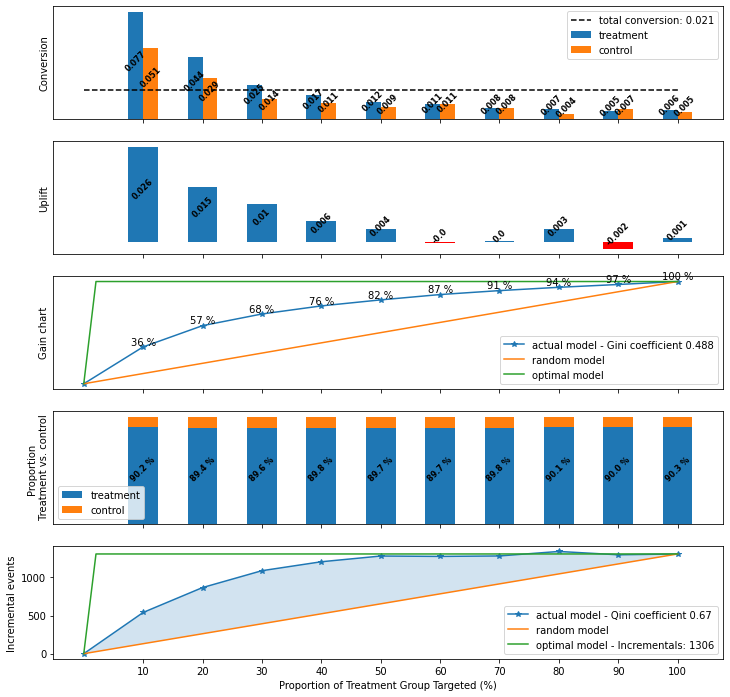

In [30]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           y_pred,
                                                           plot = True)

In [34]:
pd.to_pickle(catClass,'CatBoost_v01_qino_067.pickle')
pd.to_pickle(classTslearner,'ClassTransformation_v01.pickle')

In [31]:
#Doomy model
classTslearner2 = ClassTransformation(estimator = CatBoostClassifier(iterations=100,
                                                                    thread_count=-1, 
                                                                    random_state=42, 
                                                                    silent=True))
classTslearner2.fit(X = X_train,
                    y = y_train,
                   treatment = train_treatment)
y_pred = classTslearner2.predict(X_test)

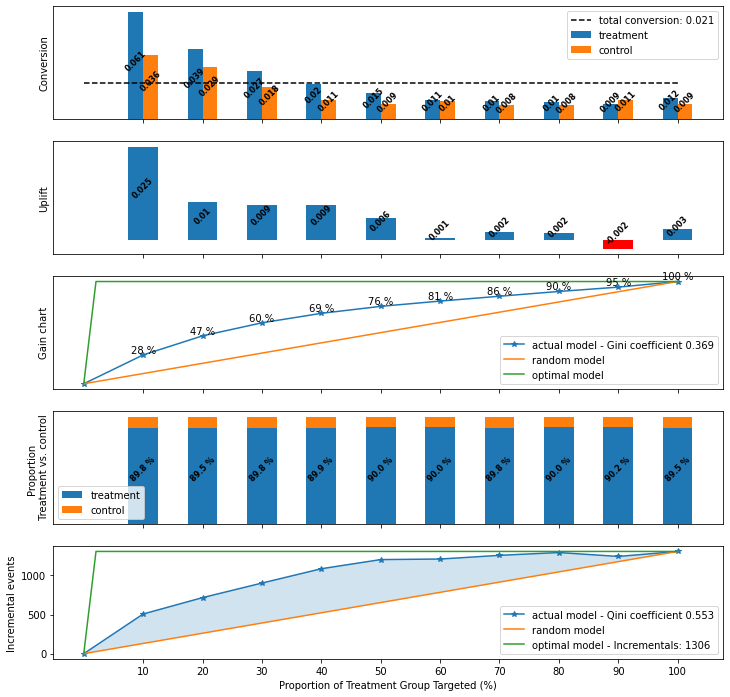

In [32]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           y_pred,
                                                           plot = True)